# 공공데이터를 활용한 미세먼지 농도 예측 프로젝트
## 단계2. 모델링(LSTM)

## 0.프로젝트 소개

### (1) 수행 목표
- 미세먼지 농도를 예측하는 머신러닝 모델을 만드세요.

#### 우리가 풀어야 하는 문제는 무엇인가요?
* 서울 지역의 미세먼지 데이터와 날씨 데이터를 활용하여,
미세먼지 예측에 관련 있는 데이터 항목으로 데이터를 구성, 전처리 하여
미세먼지 농도를 예측하는 머신러닝 모델 구현


### (2) 데이터 소개

#### 1) 기본 데이터

* 학습 데이터
    * air_2021.csv : 2021년 미세먼지 데이터
    * weather_2021.csv : 2021년 날씨 데이터
* 테스트 데이터
    * air_2022.csv : 2022년 미세먼지 데이터
    * weather_2022.csv : 2022년 날씨 데이터

#### 2) 데이터셋의 변수 소개(weather_2021)

* 증기압: 증기가 고체 또는 액체와 동적 평형 상태에 있을 때 증기의 압력 (증기가 되려는 힘)
* 이슬점 온도: 불포화 상태의 공기가 냉각될 때, 포화 상태에 도달하여 수증기의 응결이 시작되는 온도
* 일조: 일정한 물체나 땅의 겉면에 태양 광선이 비치는 시간 (1시간 중 비율)
* 일사(량): 태양으로부터 오는 태양 복사 에너지가 지표에 닿는 양 (면적당 에너지 량)
* 전운량: 하늘을 육안으로 관측하여 전부 구름일 때 10, 구름이 덮고 있는 하늘의 비율에 따라 0~10
* 중하층운량: 중층과 하층에 있는 구름의 분포량(중하층 구름이 날씨에 영향 주므로 따로 표기)
* 운형(운형약어): 구름의 종류. 약어 코드로 기재됨
* 최저운고: 가장 낮은 구름의 높이
* 현상번호(국내식): 비, 소낙비, 싸락눈, 눈보라 등의 기상현상을 나타낸 코드번호
* 지면온도: 지면 0cm 온도
* 지중온도: 땅 속 온도변수1

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Dataset

In [109]:
class FineDustDataset(Dataset):
    def __init__(self, x_path, y_path=None, sequence_length=168):
        self.x_data = pd.read_csv(x_path).values.astype("float32")
        self.sequence_length = sequence_length
        self.y_data = None

        if y_path is not None:
            self.y_data = pd.read_csv(y_path).values.astype("float32")

    def __len__(self):
        return len(self.x_data) - self.sequence_length + 1

    def __getitem__(self, idx):
        x = self.x_data[idx:idx + self.sequence_length]
        x = torch.tensor(x)

        if self.y_data is not None:
            y = self.y_data[idx + self.sequence_length - 1]  # Target is the last step in sequence
            y = torch.tensor(y, dtype=torch.float32)
            return x, y

        return x

# Model - LSTM

### RNN의 한계:
- RNN은 시계열 데이터의 순차적 특성을 잘 반영하지만, 긴 시퀀스를 처리할 때는 Long-term Dependency가 발생

#### ***현재 데이터는 시간에 따른 변화를 기준으로 기록되어 있기 때문에 LSTM을 사용하는 것이 더 적합할 것이라 예상되어 LSTM으로 학습***

In [118]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=3, dropout=0.5):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Get the output and hidden states
        _, (hn, _) = self.lstm(x)  # hn has shape (num_layers, batch_size, hidden_size)
        out = self.layer_norm(hn[-1])
        out = self.fc(out)      # We take the last hidden state
        return out.squeeze(1)       # Remove the extra dimension to match the target shape


# Trainer

In [140]:
class FineDustPredictor:
    def __init__(self, input_size=26, hidden_size=128, sequence_length=168, learning_rate=1e-3, weight_decay=1e-4, epochs=100, save_path="best_model.pth", patience=1e10, min_delta=0.0001):
        self.epochs = epochs
        self.patience = patience
        self.min_delta = min_delta
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.save_path = save_path

        # Model, Loss, Optimizer, Scheduler
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = LSTM(input_size, hidden_size, num_layers=2, dropout=0.3).to(self.device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.AdamW(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

        # For tracking metrics
        self.train_losses = []
        self.val_losses = []
        self.r2_scores = []
        self.best_r2 = -float('inf')
        self.early_stop_counter = 0

    def train(self, train_loader, val_loader):
        for epoch in range(self.epochs):
            self.model.train()
            epoch_train_loss = 0

            for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{self.epochs}", leave=True):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                targets = targets.squeeze(1)  # Adjust target shape to (batch_size,)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                epoch_train_loss += loss.item()

            self.train_losses.append(epoch_train_loss / len(train_loader))

            # Validation step
            val_loss, r2 = self.validate(val_loader)
            self.scheduler.step(val_loss)
            self.val_losses.append(val_loss)
            self.r2_scores.append(r2)

            # Check for best model and save if best
            if r2 > self.best_r2 + self.min_delta:
                self.best_r2 = r2
                torch.save(self.model.state_dict(), self.save_path)
                print('-'*100)
                print(f"New best model saved with R2 Score: {self.best_r2:.4f}")
                print('='*100)
                self.early_stop_counter = 0  # Reset counter if model improves
            else:
                self.early_stop_counter += 1

            # Early stopping condition
            if self.early_stop_counter >= self.patience:
                print("Early stopping triggered.")
                break

            print(f"Epoch [{epoch+1}/{self.epochs}], "
                  f"Train Loss: {self.train_losses[-1]:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"R2 Score: {r2:.4f}, "
                  f"Best R2 Score: {self.best_r2:.4f}")

    def validate(self, loader):
        self.model.eval()
        predictions = []
        actuals = []
        total_loss = 0

        with torch.no_grad():
            for inputs, targets in tqdm(loader, desc="Evaluating", leave=False):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                targets = targets.squeeze(1)  # Adjust target shape to (batch_size,)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_loss += loss.item()
                predictions.extend(outputs.squeeze().cpu().tolist())
                actuals.extend(targets.cpu().tolist())

        avg_loss = total_loss / len(loader)
        r2 = r2_score(actuals, predictions)
        return avg_loss, r2

    def plot_metrics(self):
        epochs = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(14, 6))

        # Plotting Train and Validation Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label="Train Loss")
        plt.plot(epochs, self.val_losses, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("MSE Loss")
        plt.title("Train and Validation Loss")
        plt.legend()

        # Plotting R2 Score
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.r2_scores, label="R2 Score", color="green")
        plt.xlabel("Epochs")
        plt.ylabel("R2 Score")
        plt.title("Validation R2 Score")
        plt.legend()

        plt.tight_layout()
        plt.show()

    def load_best_model(self):
        # Load the best model from the saved file
        self.model.load_state_dict(torch.load(self.save_path, weights_only=True))
        print("Best model loaded for testing.")

    def test(self, test_loader):
        # Ensure the best model is loaded before testing
        self.load_best_model()

        self.model.eval()
        predictions = []
        actuals = []
        total_loss = 0

        with torch.no_grad():
            for inputs, targets in tqdm(test_loader, desc="Testing", leave=True):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                targets = targets.squeeze(1)  # Adjust target shape to (batch_size,)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_loss += loss.item()
                predictions.extend(outputs.squeeze().cpu().tolist())
                actuals.extend(targets.cpu().tolist())

        avg_loss = total_loss / len(test_loader)
        r2 = r2_score(actuals, predictions)
        print(f"Test Loss: {avg_loss:.4f}, Test R2 Score: {r2:.4f}")
        return avg_loss, r2


## Train

In [141]:
train_x='./data/train_x.csv'
train_y='./data/train_y.csv'
test_x='./data/test_x.csv'
test_y='./data/test_y.csv'

#### 데이터의 분리 이유:
- 원래 1년치 데이터라 train-validation-test로 분리하면 train data의 1년치 패턴이 훼손됨
- 그러나, 최적의 모델(best model)을 선택할 때 validation 대신 test data를 사용했을 경우 이로 인해 발생할 수 있는 bias를 염려해 train과 validation 데이터를 분리하기로 결정
#### 분리 비율: 
- 일반적인 8:2가 아닌 9:1의 비율로 분리하여, 그나마 1년 전체 데이터를 유지
#### 분리 방식:
- 시계열 데이터 특성을 보존하기 위해 데이터를 섞지 않고 연속된 형태로 분리 -> 시계열 유지

In [142]:
train_dataset = FineDustDataset(x_path=train_x, y_path=train_y, sequence_length=168)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=False)
train_size = int(len(train_dataset) * 0.9)  # 90% train
val_size = len(train_dataset) - train_size  # 10% val

train_subset = torch.utils.data.Subset(train_dataset, range(train_size))
val_subset = torch.utils.data.Subset(train_dataset, range(train_size, len(train_dataset)))

train_loader = DataLoader(train_subset, batch_size=128, shuffle=False)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

In [143]:
predictor = FineDustPredictor(input_size=26, hidden_size=512, sequence_length=24, learning_rate=1e-4, weight_decay=1e-4, epochs=500)
# 7 days = 168 hours

In [144]:
predictor.train(train_loader, val_loader)

Epoch 1/500: 100%|██████████| 59/59 [00:01<00:00, 29.72it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: -0.0202
Epoch [1/500], Train Loss: 3433.6730, Val Loss: 131.9914, R2 Score: -0.0202, Best R2 Score: -0.0202


Epoch 2/500: 100%|██████████| 59/59 [00:01<00:00, 29.70it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: -0.0030
Epoch [2/500], Train Loss: 3150.0450, Val Loss: 129.9642, R2 Score: -0.0030, Best R2 Score: -0.0030


Epoch 3/500: 100%|██████████| 59/59 [00:01<00:00, 29.73it/s]


Epoch [3/500], Train Loss: 3044.1027, Val Loss: 136.9151, R2 Score: -0.0524, Best R2 Score: -0.0030


Epoch 4/500: 100%|██████████| 59/59 [00:01<00:00, 29.50it/s]


Epoch [4/500], Train Loss: 2955.1488, Val Loss: 151.2677, R2 Score: -0.1566, Best R2 Score: -0.0030


Epoch 5/500: 100%|██████████| 59/59 [00:01<00:00, 29.63it/s]


Epoch [5/500], Train Loss: 2876.7948, Val Loss: 172.2142, R2 Score: -0.3096, Best R2 Score: -0.0030


Epoch 6/500: 100%|██████████| 59/59 [00:01<00:00, 29.51it/s]


Epoch [6/500], Train Loss: 2808.3667, Val Loss: 198.6375, R2 Score: -0.5031, Best R2 Score: -0.0030


Epoch 7/500: 100%|██████████| 59/59 [00:02<00:00, 29.49it/s]


Epoch [7/500], Train Loss: 2749.5179, Val Loss: 229.3075, R2 Score: -0.7281, Best R2 Score: -0.0030


Epoch 8/500: 100%|██████████| 59/59 [00:02<00:00, 29.46it/s]


Epoch [8/500], Train Loss: 2699.6954, Val Loss: 263.0079, R2 Score: -0.9756, Best R2 Score: -0.0030


Epoch 9/500: 100%|██████████| 59/59 [00:02<00:00, 29.45it/s]


Epoch [9/500], Train Loss: 2662.8263, Val Loss: 281.9088, R2 Score: -1.1145, Best R2 Score: -0.0030


Epoch 10/500: 100%|██████████| 59/59 [00:02<00:00, 29.38it/s]


Epoch [10/500], Train Loss: 2643.8643, Val Loss: 299.9286, R2 Score: -1.2470, Best R2 Score: -0.0030


Epoch 11/500: 100%|██████████| 59/59 [00:02<00:00, 29.31it/s]


Epoch [11/500], Train Loss: 2626.9749, Val Loss: 317.9357, R2 Score: -1.3794, Best R2 Score: -0.0030


Epoch 12/500: 100%|██████████| 59/59 [00:02<00:00, 29.33it/s]


Epoch [12/500], Train Loss: 2611.7307, Val Loss: 335.9190, R2 Score: -1.5116, Best R2 Score: -0.0030


Epoch 13/500: 100%|██████████| 59/59 [00:02<00:00, 29.26it/s]


Epoch [13/500], Train Loss: 2597.9828, Val Loss: 353.7792, R2 Score: -1.6429, Best R2 Score: -0.0030


Epoch 14/500: 100%|██████████| 59/59 [00:02<00:00, 29.41it/s]


Epoch [14/500], Train Loss: 2585.5654, Val Loss: 371.3541, R2 Score: -1.7720, Best R2 Score: -0.0030


Epoch 15/500: 100%|██████████| 59/59 [00:02<00:00, 29.26it/s]


Epoch [15/500], Train Loss: 2575.0964, Val Loss: 382.4153, R2 Score: -1.8537, Best R2 Score: -0.0030


Epoch 16/500: 100%|██████████| 59/59 [00:02<00:00, 29.46it/s]


Epoch [16/500], Train Loss: 2569.5214, Val Loss: 390.8785, R2 Score: -1.9158, Best R2 Score: -0.0030


Epoch 17/500: 100%|██████████| 59/59 [00:02<00:00, 29.41it/s]


Epoch [17/500], Train Loss: 2564.6202, Val Loss: 399.8169, R2 Score: -1.9816, Best R2 Score: -0.0030


Epoch 18/500: 100%|██████████| 59/59 [00:02<00:00, 29.39it/s]


Epoch [18/500], Train Loss: 2559.9094, Val Loss: 408.3285, R2 Score: -2.0442, Best R2 Score: -0.0030


Epoch 19/500: 100%|██████████| 59/59 [00:02<00:00, 29.33it/s]


Epoch [19/500], Train Loss: 2555.5056, Val Loss: 416.8472, R2 Score: -2.1068, Best R2 Score: -0.0030


Epoch 20/500: 100%|██████████| 59/59 [00:02<00:00, 29.28it/s]


Epoch [20/500], Train Loss: 2551.3058, Val Loss: 424.9999, R2 Score: -2.1667, Best R2 Score: -0.0030


Epoch 21/500: 100%|██████████| 59/59 [00:02<00:00, 29.22it/s]


Epoch [21/500], Train Loss: 2547.1874, Val Loss: 428.7562, R2 Score: -2.1942, Best R2 Score: -0.0030


Epoch 22/500: 100%|██████████| 59/59 [00:02<00:00, 29.14it/s]


Epoch [22/500], Train Loss: 2545.2176, Val Loss: 432.2151, R2 Score: -2.2194, Best R2 Score: -0.0030


Epoch 23/500: 100%|██████████| 59/59 [00:02<00:00, 29.26it/s]


Epoch [23/500], Train Loss: 2543.2552, Val Loss: 435.2536, R2 Score: -2.2414, Best R2 Score: -0.0030


Epoch 24/500: 100%|██████████| 59/59 [00:02<00:00, 29.39it/s]


Epoch [24/500], Train Loss: 2541.2622, Val Loss: 437.3904, R2 Score: -2.2563, Best R2 Score: -0.0030


Epoch 25/500: 100%|██████████| 59/59 [00:02<00:00, 28.66it/s]


Epoch [25/500], Train Loss: 2539.2672, Val Loss: 439.1569, R2 Score: -2.2685, Best R2 Score: -0.0030


Epoch 26/500: 100%|██████████| 59/59 [00:02<00:00, 29.29it/s]


Epoch [26/500], Train Loss: 2537.0944, Val Loss: 439.5541, R2 Score: -2.2703, Best R2 Score: -0.0030


Epoch 27/500: 100%|██████████| 59/59 [00:02<00:00, 29.16it/s]


Epoch [27/500], Train Loss: 2534.0060, Val Loss: 436.9239, R2 Score: -2.2497, Best R2 Score: -0.0030


Epoch 28/500: 100%|██████████| 59/59 [00:02<00:00, 29.37it/s]


Epoch [28/500], Train Loss: 2532.5982, Val Loss: 435.2123, R2 Score: -2.2360, Best R2 Score: -0.0030


Epoch 29/500: 100%|██████████| 59/59 [00:02<00:00, 29.33it/s]


Epoch [29/500], Train Loss: 2531.0031, Val Loss: 432.8710, R2 Score: -2.2174, Best R2 Score: -0.0030


Epoch 30/500: 100%|██████████| 59/59 [00:02<00:00, 29.20it/s]


Epoch [30/500], Train Loss: 2529.2229, Val Loss: 429.8220, R2 Score: -2.1934, Best R2 Score: -0.0030


Epoch 31/500: 100%|██████████| 59/59 [00:02<00:00, 29.32it/s]


Epoch [31/500], Train Loss: 2527.3344, Val Loss: 426.7294, R2 Score: -2.1690, Best R2 Score: -0.0030


Epoch 32/500: 100%|██████████| 59/59 [00:02<00:00, 28.97it/s]


Epoch [32/500], Train Loss: 2525.0733, Val Loss: 423.1253, R2 Score: -2.1411, Best R2 Score: -0.0030


Epoch 33/500: 100%|██████████| 59/59 [00:02<00:00, 29.12it/s]


Epoch [33/500], Train Loss: 2522.0379, Val Loss: 418.6179, R2 Score: -2.1073, Best R2 Score: -0.0030


Epoch 34/500: 100%|██████████| 59/59 [00:02<00:00, 29.24it/s]


Epoch [34/500], Train Loss: 2520.7436, Val Loss: 415.6918, R2 Score: -2.0848, Best R2 Score: -0.0030


Epoch 35/500: 100%|██████████| 59/59 [00:02<00:00, 29.18it/s]


Epoch [35/500], Train Loss: 2519.4704, Val Loss: 412.9161, R2 Score: -2.0633, Best R2 Score: -0.0030


Epoch 36/500: 100%|██████████| 59/59 [00:02<00:00, 29.21it/s]


Epoch [36/500], Train Loss: 2518.0244, Val Loss: 408.8400, R2 Score: -2.0326, Best R2 Score: -0.0030


Epoch 37/500: 100%|██████████| 59/59 [00:02<00:00, 29.10it/s]


Epoch [37/500], Train Loss: 2516.4676, Val Loss: 403.9795, R2 Score: -1.9957, Best R2 Score: -0.0030


Epoch 38/500: 100%|██████████| 59/59 [00:02<00:00, 28.98it/s]


Epoch [38/500], Train Loss: 2514.7743, Val Loss: 398.9445, R2 Score: -1.9574, Best R2 Score: -0.0030


Epoch 39/500: 100%|██████████| 59/59 [00:02<00:00, 29.11it/s]


Epoch [39/500], Train Loss: 2512.6438, Val Loss: 394.9699, R2 Score: -1.9278, Best R2 Score: -0.0030


Epoch 40/500: 100%|██████████| 59/59 [00:02<00:00, 29.27it/s]


Epoch [40/500], Train Loss: 2511.7283, Val Loss: 391.6272, R2 Score: -1.9026, Best R2 Score: -0.0030


Epoch 41/500: 100%|██████████| 59/59 [00:02<00:00, 29.11it/s]


Epoch [41/500], Train Loss: 2510.6871, Val Loss: 388.4002, R2 Score: -1.8782, Best R2 Score: -0.0030


Epoch 42/500: 100%|██████████| 59/59 [00:02<00:00, 29.07it/s]


Epoch [42/500], Train Loss: 2509.5943, Val Loss: 385.0521, R2 Score: -1.8530, Best R2 Score: -0.0030


Epoch 43/500: 100%|██████████| 59/59 [00:02<00:00, 29.17it/s]


Epoch [43/500], Train Loss: 2508.6355, Val Loss: 381.7148, R2 Score: -1.8277, Best R2 Score: -0.0030


Epoch 44/500: 100%|██████████| 59/59 [00:02<00:00, 29.18it/s]


Epoch [44/500], Train Loss: 2507.4996, Val Loss: 378.3098, R2 Score: -1.8019, Best R2 Score: -0.0030


Epoch 45/500: 100%|██████████| 59/59 [00:02<00:00, 29.12it/s]


Epoch [45/500], Train Loss: 2506.3579, Val Loss: 375.7621, R2 Score: -1.7827, Best R2 Score: -0.0030


Epoch 46/500: 100%|██████████| 59/59 [00:02<00:00, 29.17it/s]


Epoch [46/500], Train Loss: 2505.5777, Val Loss: 373.2693, R2 Score: -1.7639, Best R2 Score: -0.0030


Epoch 47/500: 100%|██████████| 59/59 [00:02<00:00, 29.08it/s]


Epoch [47/500], Train Loss: 2504.9729, Val Loss: 370.9230, R2 Score: -1.7462, Best R2 Score: -0.0030


Epoch 48/500: 100%|██████████| 59/59 [00:02<00:00, 28.96it/s]


Epoch [48/500], Train Loss: 2504.0469, Val Loss: 368.4005, R2 Score: -1.7271, Best R2 Score: -0.0030


Epoch 49/500: 100%|██████████| 59/59 [00:02<00:00, 29.04it/s]


Epoch [49/500], Train Loss: 2503.2052, Val Loss: 365.8411, R2 Score: -1.7078, Best R2 Score: -0.0030


Epoch 50/500: 100%|██████████| 59/59 [00:02<00:00, 29.03it/s]


Epoch [50/500], Train Loss: 2502.3901, Val Loss: 363.1526, R2 Score: -1.6876, Best R2 Score: -0.0030


Epoch 51/500: 100%|██████████| 59/59 [00:02<00:00, 28.90it/s]


Epoch [51/500], Train Loss: 2501.7960, Val Loss: 360.6807, R2 Score: -1.6688, Best R2 Score: -0.0030


Epoch 52/500: 100%|██████████| 59/59 [00:02<00:00, 29.06it/s]


Epoch [52/500], Train Loss: 2500.8957, Val Loss: 358.0236, R2 Score: -1.6486, Best R2 Score: -0.0030


Epoch 53/500: 100%|██████████| 59/59 [00:02<00:00, 29.07it/s]


Epoch [53/500], Train Loss: 2500.0084, Val Loss: 355.0663, R2 Score: -1.6264, Best R2 Score: -0.0030


Epoch 54/500: 100%|██████████| 59/59 [00:02<00:00, 28.45it/s]


Epoch [54/500], Train Loss: 2499.1911, Val Loss: 352.1199, R2 Score: -1.6041, Best R2 Score: -0.0030


Epoch 55/500: 100%|██████████| 59/59 [00:02<00:00, 29.07it/s]


Epoch [55/500], Train Loss: 2498.0713, Val Loss: 348.8448, R2 Score: -1.5794, Best R2 Score: -0.0030


Epoch 56/500: 100%|██████████| 59/59 [00:02<00:00, 28.96it/s]


Epoch [56/500], Train Loss: 2497.2158, Val Loss: 345.6187, R2 Score: -1.5550, Best R2 Score: -0.0030


Epoch 57/500: 100%|██████████| 59/59 [00:02<00:00, 29.11it/s]


Epoch [57/500], Train Loss: 2496.1376, Val Loss: 342.1750, R2 Score: -1.5290, Best R2 Score: -0.0030


Epoch 58/500: 100%|██████████| 59/59 [00:02<00:00, 28.86it/s]


Epoch [58/500], Train Loss: 2495.1769, Val Loss: 338.4277, R2 Score: -1.5007, Best R2 Score: -0.0030


Epoch 59/500: 100%|██████████| 59/59 [00:02<00:00, 28.95it/s]


Epoch [59/500], Train Loss: 2493.9913, Val Loss: 334.4108, R2 Score: -1.4706, Best R2 Score: -0.0030


Epoch 60/500: 100%|██████████| 59/59 [00:02<00:00, 29.04it/s]


Epoch [60/500], Train Loss: 2492.9479, Val Loss: 330.4362, R2 Score: -1.4406, Best R2 Score: -0.0030


Epoch 61/500: 100%|██████████| 59/59 [00:02<00:00, 28.94it/s]


Epoch [61/500], Train Loss: 2491.9105, Val Loss: 326.1004, R2 Score: -1.4079, Best R2 Score: -0.0030


Epoch 62/500: 100%|██████████| 59/59 [00:02<00:00, 29.15it/s]


Epoch [62/500], Train Loss: 2490.6325, Val Loss: 321.5270, R2 Score: -1.3735, Best R2 Score: -0.0030


Epoch 63/500: 100%|██████████| 59/59 [00:02<00:00, 29.01it/s]


Epoch [63/500], Train Loss: 2489.3621, Val Loss: 316.6898, R2 Score: -1.3371, Best R2 Score: -0.0030


Epoch 64/500: 100%|██████████| 59/59 [00:02<00:00, 29.02it/s]


Epoch [64/500], Train Loss: 2487.8965, Val Loss: 311.4401, R2 Score: -1.2977, Best R2 Score: -0.0030


Epoch 65/500: 100%|██████████| 59/59 [00:02<00:00, 28.86it/s]


Epoch [65/500], Train Loss: 2486.4744, Val Loss: 306.1371, R2 Score: -1.2579, Best R2 Score: -0.0030


Epoch 66/500: 100%|██████████| 59/59 [00:02<00:00, 28.95it/s]


Epoch [66/500], Train Loss: 2485.2025, Val Loss: 300.6936, R2 Score: -1.2172, Best R2 Score: -0.0030


Epoch 67/500: 100%|██████████| 59/59 [00:02<00:00, 28.90it/s]


Epoch [67/500], Train Loss: 2483.7338, Val Loss: 295.2983, R2 Score: -1.1766, Best R2 Score: -0.0030


Epoch 68/500: 100%|██████████| 59/59 [00:02<00:00, 28.99it/s]


Epoch [68/500], Train Loss: 2482.1195, Val Loss: 289.8389, R2 Score: -1.1357, Best R2 Score: -0.0030


Epoch 69/500: 100%|██████████| 59/59 [00:02<00:00, 29.00it/s]


Epoch [69/500], Train Loss: 2480.8976, Val Loss: 284.3103, R2 Score: -1.0944, Best R2 Score: -0.0030


Epoch 70/500: 100%|██████████| 59/59 [00:02<00:00, 28.98it/s]


Epoch [70/500], Train Loss: 2479.4321, Val Loss: 279.0275, R2 Score: -1.0549, Best R2 Score: -0.0030


Epoch 71/500: 100%|██████████| 59/59 [00:02<00:00, 28.86it/s]


Epoch [71/500], Train Loss: 2478.3416, Val Loss: 274.0512, R2 Score: -1.0177, Best R2 Score: -0.0030


Epoch 72/500: 100%|██████████| 59/59 [00:02<00:00, 29.00it/s]


Epoch [72/500], Train Loss: 2476.5859, Val Loss: 268.6256, R2 Score: -0.9774, Best R2 Score: -0.0030


Epoch 73/500: 100%|██████████| 59/59 [00:02<00:00, 28.89it/s]


Epoch [73/500], Train Loss: 2475.5220, Val Loss: 263.5157, R2 Score: -0.9394, Best R2 Score: -0.0030


Epoch 74/500: 100%|██████████| 59/59 [00:02<00:00, 28.94it/s]


Epoch [74/500], Train Loss: 2474.2272, Val Loss: 258.7945, R2 Score: -0.9042, Best R2 Score: -0.0030


Epoch 75/500: 100%|██████████| 59/59 [00:02<00:00, 28.87it/s]


Epoch [75/500], Train Loss: 2473.0576, Val Loss: 254.1984, R2 Score: -0.8700, Best R2 Score: -0.0030


Epoch 76/500: 100%|██████████| 59/59 [00:02<00:00, 29.05it/s]


Epoch [76/500], Train Loss: 2471.5738, Val Loss: 249.5998, R2 Score: -0.8358, Best R2 Score: -0.0030


Epoch 77/500: 100%|██████████| 59/59 [00:02<00:00, 28.92it/s]


Epoch [77/500], Train Loss: 2470.3278, Val Loss: 245.0429, R2 Score: -0.8021, Best R2 Score: -0.0030


Epoch 78/500: 100%|██████████| 59/59 [00:02<00:00, 28.90it/s]


Epoch [78/500], Train Loss: 2469.2591, Val Loss: 240.8402, R2 Score: -0.7709, Best R2 Score: -0.0030


Epoch 79/500: 100%|██████████| 59/59 [00:02<00:00, 28.70it/s]


Epoch [79/500], Train Loss: 2467.8667, Val Loss: 236.2644, R2 Score: -0.7373, Best R2 Score: -0.0030


Epoch 80/500: 100%|██████████| 59/59 [00:02<00:00, 28.68it/s]


Epoch [80/500], Train Loss: 2467.1381, Val Loss: 232.0972, R2 Score: -0.7066, Best R2 Score: -0.0030


Epoch 81/500: 100%|██████████| 59/59 [00:02<00:00, 28.85it/s]


Epoch [81/500], Train Loss: 2465.2936, Val Loss: 228.0856, R2 Score: -0.6770, Best R2 Score: -0.0030


Epoch 82/500: 100%|██████████| 59/59 [00:02<00:00, 28.83it/s]


Epoch [82/500], Train Loss: 2464.6386, Val Loss: 224.1199, R2 Score: -0.6479, Best R2 Score: -0.0030


Epoch 83/500: 100%|██████████| 59/59 [00:02<00:00, 28.36it/s]


Epoch [83/500], Train Loss: 2463.4931, Val Loss: 220.1441, R2 Score: -0.6188, Best R2 Score: -0.0030


Epoch 84/500: 100%|██████████| 59/59 [00:02<00:00, 28.74it/s]


Epoch [84/500], Train Loss: 2462.3618, Val Loss: 216.3785, R2 Score: -0.5911, Best R2 Score: -0.0030


Epoch 85/500: 100%|██████████| 59/59 [00:02<00:00, 28.59it/s]


Epoch [85/500], Train Loss: 2461.4554, Val Loss: 212.9205, R2 Score: -0.5658, Best R2 Score: -0.0030


Epoch 86/500: 100%|██████████| 59/59 [00:02<00:00, 28.88it/s]


Epoch [86/500], Train Loss: 2460.3877, Val Loss: 209.3239, R2 Score: -0.5394, Best R2 Score: -0.0030


Epoch 87/500: 100%|██████████| 59/59 [00:02<00:00, 28.81it/s]


Epoch [87/500], Train Loss: 2459.2468, Val Loss: 205.9759, R2 Score: -0.5149, Best R2 Score: -0.0030


Epoch 88/500: 100%|██████████| 59/59 [00:02<00:00, 28.89it/s]


Epoch [88/500], Train Loss: 2458.1501, Val Loss: 202.2432, R2 Score: -0.4878, Best R2 Score: -0.0030


Epoch 89/500: 100%|██████████| 59/59 [00:02<00:00, 28.76it/s]


Epoch [89/500], Train Loss: 2457.2499, Val Loss: 199.3233, R2 Score: -0.4663, Best R2 Score: -0.0030


Epoch 90/500: 100%|██████████| 59/59 [00:02<00:00, 28.82it/s]


Epoch [90/500], Train Loss: 2456.4128, Val Loss: 196.3648, R2 Score: -0.4447, Best R2 Score: -0.0030


Epoch 91/500: 100%|██████████| 59/59 [00:02<00:00, 28.79it/s]


Epoch [91/500], Train Loss: 2455.3521, Val Loss: 193.0536, R2 Score: -0.4207, Best R2 Score: -0.0030


Epoch 92/500: 100%|██████████| 59/59 [00:02<00:00, 28.84it/s]


Epoch [92/500], Train Loss: 2453.8422, Val Loss: 190.1317, R2 Score: -0.3994, Best R2 Score: -0.0030


Epoch 93/500: 100%|██████████| 59/59 [00:02<00:00, 28.85it/s]


Epoch [93/500], Train Loss: 2453.0065, Val Loss: 186.8085, R2 Score: -0.3754, Best R2 Score: -0.0030


Epoch 94/500: 100%|██████████| 59/59 [00:02<00:00, 28.76it/s]


Epoch [94/500], Train Loss: 2452.2742, Val Loss: 183.9184, R2 Score: -0.3545, Best R2 Score: -0.0030


Epoch 95/500: 100%|██████████| 59/59 [00:02<00:00, 28.72it/s]


Epoch [95/500], Train Loss: 2451.5441, Val Loss: 181.3517, R2 Score: -0.3357, Best R2 Score: -0.0030


Epoch 96/500: 100%|██████████| 59/59 [00:02<00:00, 28.77it/s]


Epoch [96/500], Train Loss: 2450.4991, Val Loss: 178.6309, R2 Score: -0.3160, Best R2 Score: -0.0030


Epoch 97/500: 100%|██████████| 59/59 [00:02<00:00, 28.77it/s]


Epoch [97/500], Train Loss: 2449.5863, Val Loss: 176.0733, R2 Score: -0.2975, Best R2 Score: -0.0030


Epoch 98/500: 100%|██████████| 59/59 [00:02<00:00, 28.80it/s]


Epoch [98/500], Train Loss: 2448.8983, Val Loss: 173.8089, R2 Score: -0.2809, Best R2 Score: -0.0030


Epoch 99/500: 100%|██████████| 59/59 [00:02<00:00, 28.87it/s]


Epoch [99/500], Train Loss: 2448.3040, Val Loss: 171.6562, R2 Score: -0.2652, Best R2 Score: -0.0030


Epoch 100/500: 100%|██████████| 59/59 [00:02<00:00, 28.79it/s]


Epoch [100/500], Train Loss: 2446.8409, Val Loss: 169.0514, R2 Score: -0.2464, Best R2 Score: -0.0030


Epoch 101/500: 100%|██████████| 59/59 [00:02<00:00, 28.91it/s]


Epoch [101/500], Train Loss: 2445.7744, Val Loss: 166.5595, R2 Score: -0.2284, Best R2 Score: -0.0030


Epoch 102/500: 100%|██████████| 59/59 [00:02<00:00, 28.70it/s]


Epoch [102/500], Train Loss: 2445.2757, Val Loss: 164.3837, R2 Score: -0.2128, Best R2 Score: -0.0030


Epoch 103/500: 100%|██████████| 59/59 [00:02<00:00, 28.80it/s]


Epoch [103/500], Train Loss: 2444.6565, Val Loss: 162.5615, R2 Score: -0.1995, Best R2 Score: -0.0030


Epoch 104/500: 100%|██████████| 59/59 [00:02<00:00, 28.77it/s]


Epoch [104/500], Train Loss: 2443.3348, Val Loss: 160.1961, R2 Score: -0.1826, Best R2 Score: -0.0030


Epoch 105/500: 100%|██████████| 59/59 [00:02<00:00, 28.79it/s]


Epoch [105/500], Train Loss: 2442.8570, Val Loss: 158.1977, R2 Score: -0.1681, Best R2 Score: -0.0030


Epoch 106/500: 100%|██████████| 59/59 [00:02<00:00, 28.76it/s]


Epoch [106/500], Train Loss: 2442.2844, Val Loss: 156.5132, R2 Score: -0.1559, Best R2 Score: -0.0030


Epoch 107/500: 100%|██████████| 59/59 [00:02<00:00, 28.76it/s]


Epoch [107/500], Train Loss: 2441.4536, Val Loss: 154.8692, R2 Score: -0.1440, Best R2 Score: -0.0030


Epoch 108/500: 100%|██████████| 59/59 [00:02<00:00, 28.66it/s]


Epoch [108/500], Train Loss: 2440.2654, Val Loss: 152.9070, R2 Score: -0.1299, Best R2 Score: -0.0030


Epoch 109/500: 100%|██████████| 59/59 [00:02<00:00, 28.79it/s]


Epoch [109/500], Train Loss: 2439.5116, Val Loss: 150.9376, R2 Score: -0.1158, Best R2 Score: -0.0030


Epoch 110/500: 100%|██████████| 59/59 [00:02<00:00, 28.82it/s]


Epoch [110/500], Train Loss: 2438.3674, Val Loss: 149.4742, R2 Score: -0.1052, Best R2 Score: -0.0030


Epoch 111/500: 100%|██████████| 59/59 [00:02<00:00, 28.76it/s]


Epoch [111/500], Train Loss: 2438.2356, Val Loss: 148.1638, R2 Score: -0.0957, Best R2 Score: -0.0030


Epoch 112/500: 100%|██████████| 59/59 [00:02<00:00, 28.33it/s]


Epoch [112/500], Train Loss: 2436.8503, Val Loss: 146.4947, R2 Score: -0.0837, Best R2 Score: -0.0030


Epoch 113/500: 100%|██████████| 59/59 [00:02<00:00, 28.82it/s]


Epoch [113/500], Train Loss: 2436.5979, Val Loss: 144.9756, R2 Score: -0.0728, Best R2 Score: -0.0030


Epoch 114/500: 100%|██████████| 59/59 [00:02<00:00, 28.63it/s]


Epoch [114/500], Train Loss: 2435.8174, Val Loss: 143.4247, R2 Score: -0.0617, Best R2 Score: -0.0030


Epoch 115/500: 100%|██████████| 59/59 [00:02<00:00, 28.87it/s]


Epoch [115/500], Train Loss: 2434.5969, Val Loss: 141.9744, R2 Score: -0.0513, Best R2 Score: -0.0030


Epoch 116/500: 100%|██████████| 59/59 [00:02<00:00, 28.84it/s]


Epoch [116/500], Train Loss: 2434.8072, Val Loss: 141.2103, R2 Score: -0.0457, Best R2 Score: -0.0030


Epoch 117/500: 100%|██████████| 59/59 [00:02<00:00, 28.70it/s]


Epoch [117/500], Train Loss: 2433.2658, Val Loss: 139.6685, R2 Score: -0.0348, Best R2 Score: -0.0030


Epoch 118/500: 100%|██████████| 59/59 [00:02<00:00, 28.75it/s]


Epoch [118/500], Train Loss: 2432.5880, Val Loss: 138.5700, R2 Score: -0.0269, Best R2 Score: -0.0030


Epoch 119/500: 100%|██████████| 59/59 [00:02<00:00, 28.69it/s]


Epoch [119/500], Train Loss: 2432.2140, Val Loss: 137.2761, R2 Score: -0.0176, Best R2 Score: -0.0030


Epoch 120/500: 100%|██████████| 59/59 [00:02<00:00, 28.70it/s]


Epoch [120/500], Train Loss: 2430.9633, Val Loss: 135.8874, R2 Score: -0.0077, Best R2 Score: -0.0030


Epoch 121/500: 100%|██████████| 59/59 [00:02<00:00, 28.72it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0006
Epoch [121/500], Train Loss: 2430.5231, Val Loss: 134.7285, R2 Score: 0.0006, Best R2 Score: 0.0006


Epoch 122/500: 100%|██████████| 59/59 [00:02<00:00, 28.90it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0068
Epoch [122/500], Train Loss: 2429.2562, Val Loss: 133.8694, R2 Score: 0.0068, Best R2 Score: 0.0068


Epoch 123/500: 100%|██████████| 59/59 [00:02<00:00, 28.70it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0156
Epoch [123/500], Train Loss: 2428.8688, Val Loss: 132.6451, R2 Score: 0.0156, Best R2 Score: 0.0156


Epoch 124/500: 100%|██████████| 59/59 [00:02<00:00, 28.85it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0246
Epoch [124/500], Train Loss: 2428.3930, Val Loss: 131.3934, R2 Score: 0.0246, Best R2 Score: 0.0246


Epoch 125/500: 100%|██████████| 59/59 [00:02<00:00, 28.88it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0322
Epoch [125/500], Train Loss: 2427.6831, Val Loss: 130.3266, R2 Score: 0.0322, Best R2 Score: 0.0322


Epoch 126/500: 100%|██████████| 59/59 [00:02<00:00, 28.94it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0391
Epoch [126/500], Train Loss: 2426.9061, Val Loss: 129.3715, R2 Score: 0.0391, Best R2 Score: 0.0391


Epoch 127/500: 100%|██████████| 59/59 [00:02<00:00, 29.04it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0460
Epoch [127/500], Train Loss: 2425.7118, Val Loss: 128.4020, R2 Score: 0.0460, Best R2 Score: 0.0460


Epoch 128/500: 100%|██████████| 59/59 [00:02<00:00, 28.84it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0542
Epoch [128/500], Train Loss: 2425.5478, Val Loss: 127.2574, R2 Score: 0.0542, Best R2 Score: 0.0542


Epoch 129/500: 100%|██████████| 59/59 [00:02<00:00, 28.98it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0598
Epoch [129/500], Train Loss: 2425.5073, Val Loss: 126.4855, R2 Score: 0.0598, Best R2 Score: 0.0598


Epoch 130/500: 100%|██████████| 59/59 [00:02<00:00, 28.85it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0677
Epoch [130/500], Train Loss: 2423.8364, Val Loss: 125.3739, R2 Score: 0.0677, Best R2 Score: 0.0677


Epoch 131/500: 100%|██████████| 59/59 [00:02<00:00, 28.87it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0704
Epoch [131/500], Train Loss: 2424.0069, Val Loss: 125.0052, R2 Score: 0.0704, Best R2 Score: 0.0704


Epoch 132/500: 100%|██████████| 59/59 [00:02<00:00, 28.90it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0778
Epoch [132/500], Train Loss: 2423.0666, Val Loss: 123.9679, R2 Score: 0.0778, Best R2 Score: 0.0778


Epoch 133/500: 100%|██████████| 59/59 [00:02<00:00, 28.72it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0852
Epoch [133/500], Train Loss: 2421.9060, Val Loss: 122.9290, R2 Score: 0.0852, Best R2 Score: 0.0852


Epoch 134/500: 100%|██████████| 59/59 [00:02<00:00, 28.90it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0918
Epoch [134/500], Train Loss: 2421.3592, Val Loss: 122.0014, R2 Score: 0.0918, Best R2 Score: 0.0918


Epoch 135/500: 100%|██████████| 59/59 [00:02<00:00, 29.02it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.0965
Epoch [135/500], Train Loss: 2420.7009, Val Loss: 121.3455, R2 Score: 0.0965, Best R2 Score: 0.0965


Epoch 136/500: 100%|██████████| 59/59 [00:02<00:00, 28.93it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1034
Epoch [136/500], Train Loss: 2420.0964, Val Loss: 120.3897, R2 Score: 0.1034, Best R2 Score: 0.1034


Epoch 137/500: 100%|██████████| 59/59 [00:02<00:00, 28.79it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1090
Epoch [137/500], Train Loss: 2419.3069, Val Loss: 119.6073, R2 Score: 0.1090, Best R2 Score: 0.1090


Epoch 138/500: 100%|██████████| 59/59 [00:02<00:00, 28.67it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1130
Epoch [138/500], Train Loss: 2418.3848, Val Loss: 119.0446, R2 Score: 0.1130, Best R2 Score: 0.1130


Epoch 139/500: 100%|██████████| 59/59 [00:02<00:00, 28.89it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1176
Epoch [139/500], Train Loss: 2418.4716, Val Loss: 118.4100, R2 Score: 0.1176, Best R2 Score: 0.1176


Epoch 140/500: 100%|██████████| 59/59 [00:02<00:00, 28.31it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1246
Epoch [140/500], Train Loss: 2417.5259, Val Loss: 117.4393, R2 Score: 0.1246, Best R2 Score: 0.1246


Epoch 141/500: 100%|██████████| 59/59 [00:02<00:00, 28.66it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1299
Epoch [141/500], Train Loss: 2416.3099, Val Loss: 116.7107, R2 Score: 0.1299, Best R2 Score: 0.1299


Epoch 142/500: 100%|██████████| 59/59 [00:02<00:00, 28.60it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1333
Epoch [142/500], Train Loss: 2416.5631, Val Loss: 116.2371, R2 Score: 0.1333, Best R2 Score: 0.1333


Epoch 143/500: 100%|██████████| 59/59 [00:02<00:00, 28.66it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1405
Epoch [143/500], Train Loss: 2415.3560, Val Loss: 115.2238, R2 Score: 0.1405, Best R2 Score: 0.1405


Epoch 144/500: 100%|██████████| 59/59 [00:02<00:00, 28.81it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1415
Epoch [144/500], Train Loss: 2415.3337, Val Loss: 115.0767, R2 Score: 0.1415, Best R2 Score: 0.1415


Epoch 145/500: 100%|██████████| 59/59 [00:02<00:00, 28.81it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1489
Epoch [145/500], Train Loss: 2414.5544, Val Loss: 114.0433, R2 Score: 0.1489, Best R2 Score: 0.1489


Epoch 146/500: 100%|██████████| 59/59 [00:02<00:00, 28.77it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1552
Epoch [146/500], Train Loss: 2413.7074, Val Loss: 113.1867, R2 Score: 0.1552, Best R2 Score: 0.1552


Epoch 147/500: 100%|██████████| 59/59 [00:02<00:00, 28.75it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1573
Epoch [147/500], Train Loss: 2412.6206, Val Loss: 112.8754, R2 Score: 0.1573, Best R2 Score: 0.1573


Epoch 148/500: 100%|██████████| 59/59 [00:02<00:00, 28.69it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1623
Epoch [148/500], Train Loss: 2412.1018, Val Loss: 112.2087, R2 Score: 0.1623, Best R2 Score: 0.1623


Epoch 149/500: 100%|██████████| 59/59 [00:02<00:00, 28.45it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1707
Epoch [149/500], Train Loss: 2411.4548, Val Loss: 111.0648, R2 Score: 0.1707, Best R2 Score: 0.1707


Epoch 150/500: 100%|██████████| 59/59 [00:02<00:00, 28.75it/s]


Epoch [150/500], Train Loss: 2411.3644, Val Loss: 111.3014, R2 Score: 0.1688, Best R2 Score: 0.1707


Epoch 151/500: 100%|██████████| 59/59 [00:02<00:00, 28.66it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1747
Epoch [151/500], Train Loss: 2411.1117, Val Loss: 110.4895, R2 Score: 0.1747, Best R2 Score: 0.1747


Epoch 152/500: 100%|██████████| 59/59 [00:02<00:00, 28.90it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1795
Epoch [152/500], Train Loss: 2409.6006, Val Loss: 109.8288, R2 Score: 0.1795, Best R2 Score: 0.1795


Epoch 153/500: 100%|██████████| 59/59 [00:02<00:00, 28.75it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1849
Epoch [153/500], Train Loss: 2408.8244, Val Loss: 109.1067, R2 Score: 0.1849, Best R2 Score: 0.1849


Epoch 154/500: 100%|██████████| 59/59 [00:02<00:00, 28.73it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1887
Epoch [154/500], Train Loss: 2408.3140, Val Loss: 108.5911, R2 Score: 0.1887, Best R2 Score: 0.1887


Epoch 155/500: 100%|██████████| 59/59 [00:02<00:00, 28.83it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1920
Epoch [155/500], Train Loss: 2408.4365, Val Loss: 108.1238, R2 Score: 0.1920, Best R2 Score: 0.1920


Epoch 156/500: 100%|██████████| 59/59 [00:02<00:00, 28.76it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1936
Epoch [156/500], Train Loss: 2406.9164, Val Loss: 107.8982, R2 Score: 0.1936, Best R2 Score: 0.1936


Epoch 157/500: 100%|██████████| 59/59 [00:02<00:00, 28.76it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.1979
Epoch [157/500], Train Loss: 2407.1424, Val Loss: 107.2967, R2 Score: 0.1979, Best R2 Score: 0.1979


Epoch 158/500: 100%|██████████| 59/59 [00:02<00:00, 28.75it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2052
Epoch [158/500], Train Loss: 2405.8808, Val Loss: 106.3117, R2 Score: 0.2052, Best R2 Score: 0.2052


Epoch 159/500: 100%|██████████| 59/59 [00:02<00:00, 28.84it/s]


Epoch [159/500], Train Loss: 2405.6649, Val Loss: 106.5491, R2 Score: 0.2033, Best R2 Score: 0.2052


Epoch 160/500: 100%|██████████| 59/59 [00:02<00:00, 28.68it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2097
Epoch [160/500], Train Loss: 2405.1158, Val Loss: 105.7010, R2 Score: 0.2097, Best R2 Score: 0.2097


Epoch 161/500: 100%|██████████| 59/59 [00:02<00:00, 28.81it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2144
Epoch [161/500], Train Loss: 2404.0840, Val Loss: 105.0810, R2 Score: 0.2144, Best R2 Score: 0.2144


Epoch 162/500: 100%|██████████| 59/59 [00:02<00:00, 28.86it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2159
Epoch [162/500], Train Loss: 2403.5802, Val Loss: 104.8610, R2 Score: 0.2159, Best R2 Score: 0.2159


Epoch 163/500: 100%|██████████| 59/59 [00:02<00:00, 28.77it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2232
Epoch [163/500], Train Loss: 2402.4125, Val Loss: 103.8732, R2 Score: 0.2232, Best R2 Score: 0.2232


Epoch 164/500: 100%|██████████| 59/59 [00:02<00:00, 28.84it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2258
Epoch [164/500], Train Loss: 2401.7213, Val Loss: 103.5183, R2 Score: 0.2258, Best R2 Score: 0.2258


Epoch 165/500: 100%|██████████| 59/59 [00:02<00:00, 28.69it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2294
Epoch [165/500], Train Loss: 2401.7825, Val Loss: 103.0422, R2 Score: 0.2294, Best R2 Score: 0.2294


Epoch 166/500: 100%|██████████| 59/59 [00:02<00:00, 28.95it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2297
Epoch [166/500], Train Loss: 2401.4612, Val Loss: 102.9755, R2 Score: 0.2297, Best R2 Score: 0.2297


Epoch 167/500: 100%|██████████| 59/59 [00:02<00:00, 28.93it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2340
Epoch [167/500], Train Loss: 2400.4391, Val Loss: 102.3843, R2 Score: 0.2340, Best R2 Score: 0.2340


Epoch 168/500: 100%|██████████| 59/59 [00:02<00:00, 28.52it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2376
Epoch [168/500], Train Loss: 2400.0863, Val Loss: 101.8992, R2 Score: 0.2376, Best R2 Score: 0.2376


Epoch 169/500: 100%|██████████| 59/59 [00:02<00:00, 28.88it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2406
Epoch [169/500], Train Loss: 2398.8723, Val Loss: 101.4859, R2 Score: 0.2406, Best R2 Score: 0.2406


Epoch 170/500: 100%|██████████| 59/59 [00:02<00:00, 28.77it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2453
Epoch [170/500], Train Loss: 2398.8593, Val Loss: 100.8379, R2 Score: 0.2453, Best R2 Score: 0.2453


Epoch 171/500: 100%|██████████| 59/59 [00:02<00:00, 28.61it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2475
Epoch [171/500], Train Loss: 2398.3153, Val Loss: 100.5233, R2 Score: 0.2475, Best R2 Score: 0.2475


Epoch 172/500: 100%|██████████| 59/59 [00:02<00:00, 28.85it/s]


Epoch [172/500], Train Loss: 2398.2380, Val Loss: 100.5052, R2 Score: 0.2475, Best R2 Score: 0.2475


Epoch 173/500: 100%|██████████| 59/59 [00:02<00:00, 28.83it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2514
Epoch [173/500], Train Loss: 2397.8109, Val Loss: 99.9653, R2 Score: 0.2514, Best R2 Score: 0.2514


Epoch 174/500: 100%|██████████| 59/59 [00:02<00:00, 28.88it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2572
Epoch [174/500], Train Loss: 2396.6761, Val Loss: 99.1853, R2 Score: 0.2572, Best R2 Score: 0.2572


Epoch 175/500: 100%|██████████| 59/59 [00:02<00:00, 29.00it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2591
Epoch [175/500], Train Loss: 2396.0386, Val Loss: 98.9101, R2 Score: 0.2591, Best R2 Score: 0.2591


Epoch 176/500: 100%|██████████| 59/59 [00:02<00:00, 28.96it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2606
Epoch [176/500], Train Loss: 2395.6560, Val Loss: 98.7114, R2 Score: 0.2606, Best R2 Score: 0.2606


Epoch 177/500: 100%|██████████| 59/59 [00:02<00:00, 28.98it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2654
Epoch [177/500], Train Loss: 2394.9839, Val Loss: 98.0603, R2 Score: 0.2654, Best R2 Score: 0.2654


Epoch 178/500: 100%|██████████| 59/59 [00:02<00:00, 28.99it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2669
Epoch [178/500], Train Loss: 2394.3551, Val Loss: 97.8619, R2 Score: 0.2669, Best R2 Score: 0.2669


Epoch 179/500: 100%|██████████| 59/59 [00:02<00:00, 28.95it/s]


Epoch [179/500], Train Loss: 2394.0267, Val Loss: 98.0429, R2 Score: 0.2654, Best R2 Score: 0.2669


Epoch 180/500: 100%|██████████| 59/59 [00:02<00:00, 28.76it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2747
Epoch [180/500], Train Loss: 2392.4035, Val Loss: 96.8031, R2 Score: 0.2747, Best R2 Score: 0.2747


Epoch 181/500: 100%|██████████| 59/59 [00:02<00:00, 28.88it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2795
Epoch [181/500], Train Loss: 2392.0555, Val Loss: 96.1678, R2 Score: 0.2795, Best R2 Score: 0.2795


Epoch 182/500: 100%|██████████| 59/59 [00:02<00:00, 28.89it/s]


Epoch [182/500], Train Loss: 2392.2886, Val Loss: 97.2731, R2 Score: 0.2712, Best R2 Score: 0.2795


Epoch 183/500: 100%|██████████| 59/59 [00:02<00:00, 28.82it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2796
Epoch [183/500], Train Loss: 2391.9486, Val Loss: 96.1303, R2 Score: 0.2796, Best R2 Score: 0.2796


Epoch 184/500: 100%|██████████| 59/59 [00:02<00:00, 28.85it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2808
Epoch [184/500], Train Loss: 2390.6995, Val Loss: 95.9725, R2 Score: 0.2808, Best R2 Score: 0.2808


Epoch 185/500: 100%|██████████| 59/59 [00:02<00:00, 29.11it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2852
Epoch [185/500], Train Loss: 2390.0211, Val Loss: 95.3809, R2 Score: 0.2852, Best R2 Score: 0.2852


Epoch 186/500: 100%|██████████| 59/59 [00:02<00:00, 28.93it/s]


Epoch [186/500], Train Loss: 2389.8353, Val Loss: 95.3862, R2 Score: 0.2851, Best R2 Score: 0.2852


Epoch 187/500: 100%|██████████| 59/59 [00:02<00:00, 28.55it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2904
Epoch [187/500], Train Loss: 2389.2954, Val Loss: 94.6750, R2 Score: 0.2904, Best R2 Score: 0.2904


Epoch 188/500: 100%|██████████| 59/59 [00:02<00:00, 28.96it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2939
Epoch [188/500], Train Loss: 2388.6461, Val Loss: 94.1912, R2 Score: 0.2939, Best R2 Score: 0.2939


Epoch 189/500: 100%|██████████| 59/59 [00:02<00:00, 28.95it/s]


Epoch [189/500], Train Loss: 2387.6305, Val Loss: 94.9424, R2 Score: 0.2882, Best R2 Score: 0.2939


Epoch 190/500: 100%|██████████| 59/59 [00:02<00:00, 28.82it/s]


Epoch [190/500], Train Loss: 2387.3687, Val Loss: 94.1643, R2 Score: 0.2940, Best R2 Score: 0.2939


Epoch 191/500: 100%|██████████| 59/59 [00:02<00:00, 28.84it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.2986
Epoch [191/500], Train Loss: 2386.8043, Val Loss: 93.5312, R2 Score: 0.2986, Best R2 Score: 0.2986


Epoch 192/500: 100%|██████████| 59/59 [00:02<00:00, 28.91it/s]


Epoch [192/500], Train Loss: 2386.2195, Val Loss: 93.5725, R2 Score: 0.2983, Best R2 Score: 0.2986


Epoch 193/500: 100%|██████████| 59/59 [00:02<00:00, 28.68it/s]


Epoch [193/500], Train Loss: 2385.5639, Val Loss: 93.5778, R2 Score: 0.2981, Best R2 Score: 0.2986


Epoch 194/500: 100%|██████████| 59/59 [00:02<00:00, 28.66it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3026
Epoch [194/500], Train Loss: 2385.6247, Val Loss: 92.9568, R2 Score: 0.3026, Best R2 Score: 0.3026


Epoch 195/500: 100%|██████████| 59/59 [00:02<00:00, 28.92it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3042
Epoch [195/500], Train Loss: 2384.4155, Val Loss: 92.7316, R2 Score: 0.3042, Best R2 Score: 0.3042


Epoch 196/500: 100%|██████████| 59/59 [00:02<00:00, 28.98it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3075
Epoch [196/500], Train Loss: 2384.1538, Val Loss: 92.2960, R2 Score: 0.3075, Best R2 Score: 0.3075


Epoch 197/500: 100%|██████████| 59/59 [00:02<00:00, 28.32it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3082
Epoch [197/500], Train Loss: 2383.8744, Val Loss: 92.2063, R2 Score: 0.3082, Best R2 Score: 0.3082


Epoch 198/500: 100%|██████████| 59/59 [00:02<00:00, 28.81it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3099
Epoch [198/500], Train Loss: 2382.4510, Val Loss: 91.9715, R2 Score: 0.3099, Best R2 Score: 0.3099


Epoch 199/500: 100%|██████████| 59/59 [00:02<00:00, 28.86it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3120
Epoch [199/500], Train Loss: 2382.8803, Val Loss: 91.6862, R2 Score: 0.3120, Best R2 Score: 0.3120


Epoch 200/500: 100%|██████████| 59/59 [00:02<00:00, 28.97it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3155
Epoch [200/500], Train Loss: 2381.9321, Val Loss: 91.2154, R2 Score: 0.3155, Best R2 Score: 0.3155


Epoch 201/500: 100%|██████████| 59/59 [00:02<00:00, 28.87it/s]


Epoch [201/500], Train Loss: 2381.3075, Val Loss: 91.4114, R2 Score: 0.3140, Best R2 Score: 0.3155


Epoch 202/500: 100%|██████████| 59/59 [00:02<00:00, 28.83it/s]


Epoch [202/500], Train Loss: 2380.8481, Val Loss: 91.2950, R2 Score: 0.3147, Best R2 Score: 0.3155


Epoch 203/500: 100%|██████████| 59/59 [00:02<00:00, 28.83it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3192
Epoch [203/500], Train Loss: 2380.2521, Val Loss: 90.6995, R2 Score: 0.3192, Best R2 Score: 0.3192


Epoch 204/500: 100%|██████████| 59/59 [00:02<00:00, 28.89it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3215
Epoch [204/500], Train Loss: 2379.7967, Val Loss: 90.3988, R2 Score: 0.3215, Best R2 Score: 0.3215


Epoch 205/500: 100%|██████████| 59/59 [00:02<00:00, 28.86it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3217
Epoch [205/500], Train Loss: 2379.2044, Val Loss: 90.3542, R2 Score: 0.3217, Best R2 Score: 0.3217


Epoch 206/500: 100%|██████████| 59/59 [00:02<00:00, 28.92it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3270
Epoch [206/500], Train Loss: 2378.3354, Val Loss: 89.6446, R2 Score: 0.3270, Best R2 Score: 0.3270


Epoch 207/500: 100%|██████████| 59/59 [00:02<00:00, 28.83it/s]


Epoch [207/500], Train Loss: 2377.8332, Val Loss: 89.8496, R2 Score: 0.3254, Best R2 Score: 0.3270


Epoch 208/500: 100%|██████████| 59/59 [00:02<00:00, 28.79it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3276
Epoch [208/500], Train Loss: 2377.5643, Val Loss: 89.5542, R2 Score: 0.3276, Best R2 Score: 0.3276


Epoch 209/500: 100%|██████████| 59/59 [00:02<00:00, 28.76it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3297
Epoch [209/500], Train Loss: 2377.0318, Val Loss: 89.2498, R2 Score: 0.3297, Best R2 Score: 0.3297


Epoch 210/500: 100%|██████████| 59/59 [00:02<00:00, 28.75it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3343
Epoch [210/500], Train Loss: 2375.8411, Val Loss: 88.6310, R2 Score: 0.3343, Best R2 Score: 0.3343


Epoch 211/500: 100%|██████████| 59/59 [00:02<00:00, 28.90it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3370
Epoch [211/500], Train Loss: 2375.4793, Val Loss: 88.2853, R2 Score: 0.3370, Best R2 Score: 0.3370


Epoch 212/500: 100%|██████████| 59/59 [00:02<00:00, 28.90it/s]


Epoch [212/500], Train Loss: 2374.5626, Val Loss: 88.3995, R2 Score: 0.3360, Best R2 Score: 0.3370


Epoch 213/500: 100%|██████████| 59/59 [00:02<00:00, 28.82it/s]


Epoch [213/500], Train Loss: 2375.0948, Val Loss: 88.7050, R2 Score: 0.3337, Best R2 Score: 0.3370


Epoch 214/500: 100%|██████████| 59/59 [00:02<00:00, 28.81it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3386
Epoch [214/500], Train Loss: 2374.1932, Val Loss: 88.0494, R2 Score: 0.3386, Best R2 Score: 0.3386


Epoch 215/500: 100%|██████████| 59/59 [00:02<00:00, 28.59it/s]


Epoch [215/500], Train Loss: 2373.4155, Val Loss: 88.2260, R2 Score: 0.3372, Best R2 Score: 0.3386


Epoch 216/500: 100%|██████████| 59/59 [00:02<00:00, 28.87it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3402
Epoch [216/500], Train Loss: 2373.2981, Val Loss: 87.8162, R2 Score: 0.3402, Best R2 Score: 0.3402


Epoch 217/500: 100%|██████████| 59/59 [00:02<00:00, 28.94it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3427
Epoch [217/500], Train Loss: 2372.4985, Val Loss: 87.4668, R2 Score: 0.3427, Best R2 Score: 0.3427


Epoch 218/500: 100%|██████████| 59/59 [00:02<00:00, 28.86it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3444
Epoch [218/500], Train Loss: 2371.6222, Val Loss: 87.2600, R2 Score: 0.3444, Best R2 Score: 0.3444


Epoch 219/500: 100%|██████████| 59/59 [00:02<00:00, 28.75it/s]


Epoch [219/500], Train Loss: 2371.6269, Val Loss: 87.6994, R2 Score: 0.3409, Best R2 Score: 0.3444


Epoch 220/500: 100%|██████████| 59/59 [00:02<00:00, 28.88it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3495
Epoch [220/500], Train Loss: 2370.6016, Val Loss: 86.5573, R2 Score: 0.3495, Best R2 Score: 0.3495


Epoch 221/500: 100%|██████████| 59/59 [00:02<00:00, 28.65it/s]


Epoch [221/500], Train Loss: 2370.8638, Val Loss: 86.7763, R2 Score: 0.3479, Best R2 Score: 0.3495


Epoch 222/500: 100%|██████████| 59/59 [00:02<00:00, 28.59it/s]


Epoch [222/500], Train Loss: 2370.1400, Val Loss: 86.5941, R2 Score: 0.3491, Best R2 Score: 0.3495


Epoch 223/500: 100%|██████████| 59/59 [00:02<00:00, 28.79it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3525
Epoch [223/500], Train Loss: 2368.4950, Val Loss: 86.1426, R2 Score: 0.3525, Best R2 Score: 0.3525


Epoch 224/500: 100%|██████████| 59/59 [00:02<00:00, 28.84it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3527
Epoch [224/500], Train Loss: 2368.3475, Val Loss: 86.1096, R2 Score: 0.3527, Best R2 Score: 0.3527


Epoch 225/500: 100%|██████████| 59/59 [00:02<00:00, 28.25it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3550
Epoch [225/500], Train Loss: 2368.2413, Val Loss: 85.8071, R2 Score: 0.3550, Best R2 Score: 0.3550


Epoch 226/500: 100%|██████████| 59/59 [00:02<00:00, 28.84it/s]


Epoch [226/500], Train Loss: 2368.6838, Val Loss: 85.9919, R2 Score: 0.3536, Best R2 Score: 0.3550


Epoch 227/500: 100%|██████████| 59/59 [00:02<00:00, 28.84it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3576
Epoch [227/500], Train Loss: 2366.8441, Val Loss: 85.4341, R2 Score: 0.3576, Best R2 Score: 0.3576


Epoch 228/500: 100%|██████████| 59/59 [00:02<00:00, 28.87it/s]


Epoch [228/500], Train Loss: 2366.8824, Val Loss: 85.6015, R2 Score: 0.3564, Best R2 Score: 0.3576


Epoch 229/500: 100%|██████████| 59/59 [00:02<00:00, 28.80it/s]


Epoch [229/500], Train Loss: 2366.8562, Val Loss: 85.6812, R2 Score: 0.3557, Best R2 Score: 0.3576


Epoch 230/500: 100%|██████████| 59/59 [00:02<00:00, 28.88it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3619
Epoch [230/500], Train Loss: 2366.1458, Val Loss: 84.8483, R2 Score: 0.3619, Best R2 Score: 0.3619


Epoch 231/500: 100%|██████████| 59/59 [00:02<00:00, 28.81it/s]


Epoch [231/500], Train Loss: 2364.9617, Val Loss: 84.9945, R2 Score: 0.3608, Best R2 Score: 0.3619


Epoch 232/500: 100%|██████████| 59/59 [00:02<00:00, 28.65it/s]


Epoch [232/500], Train Loss: 2364.8269, Val Loss: 84.9068, R2 Score: 0.3614, Best R2 Score: 0.3619


Epoch 233/500: 100%|██████████| 59/59 [00:02<00:00, 28.77it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3631
Epoch [233/500], Train Loss: 2364.2214, Val Loss: 84.6872, R2 Score: 0.3631, Best R2 Score: 0.3631


Epoch 234/500: 100%|██████████| 59/59 [00:02<00:00, 28.87it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3647
Epoch [234/500], Train Loss: 2363.5768, Val Loss: 84.4774, R2 Score: 0.3647, Best R2 Score: 0.3647


Epoch 235/500: 100%|██████████| 59/59 [00:02<00:00, 28.82it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3658
Epoch [235/500], Train Loss: 2363.4168, Val Loss: 84.3138, R2 Score: 0.3658, Best R2 Score: 0.3658


Epoch 236/500: 100%|██████████| 59/59 [00:02<00:00, 28.62it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3680
Epoch [236/500], Train Loss: 2362.6114, Val Loss: 84.0052, R2 Score: 0.3680, Best R2 Score: 0.3680


Epoch 237/500: 100%|██████████| 59/59 [00:02<00:00, 28.92it/s]


Epoch [237/500], Train Loss: 2362.4233, Val Loss: 84.4704, R2 Score: 0.3643, Best R2 Score: 0.3680


Epoch 238/500: 100%|██████████| 59/59 [00:02<00:00, 28.75it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3686
Epoch [238/500], Train Loss: 2361.7428, Val Loss: 83.9051, R2 Score: 0.3686, Best R2 Score: 0.3686


Epoch 239/500: 100%|██████████| 59/59 [00:02<00:00, 28.92it/s]


Epoch [239/500], Train Loss: 2361.5700, Val Loss: 84.7252, R2 Score: 0.3624, Best R2 Score: 0.3686


Epoch 240/500: 100%|██████████| 59/59 [00:02<00:00, 28.77it/s]


Epoch [240/500], Train Loss: 2361.7742, Val Loss: 84.3474, R2 Score: 0.3650, Best R2 Score: 0.3686


Epoch 241/500: 100%|██████████| 59/59 [00:02<00:00, 28.59it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3701
Epoch [241/500], Train Loss: 2360.1742, Val Loss: 83.6683, R2 Score: 0.3701, Best R2 Score: 0.3701


Epoch 242/500: 100%|██████████| 59/59 [00:02<00:00, 28.75it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3723
Epoch [242/500], Train Loss: 2359.6439, Val Loss: 83.3980, R2 Score: 0.3723, Best R2 Score: 0.3723


Epoch 243/500: 100%|██████████| 59/59 [00:02<00:00, 29.00it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3733
Epoch [243/500], Train Loss: 2359.6288, Val Loss: 83.2699, R2 Score: 0.3733, Best R2 Score: 0.3733


Epoch 244/500: 100%|██████████| 59/59 [00:02<00:00, 28.90it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3780
Epoch [244/500], Train Loss: 2358.1874, Val Loss: 82.6402, R2 Score: 0.3780, Best R2 Score: 0.3780


Epoch 245/500: 100%|██████████| 59/59 [00:02<00:00, 28.99it/s]


Epoch [245/500], Train Loss: 2358.3620, Val Loss: 82.7807, R2 Score: 0.3772, Best R2 Score: 0.3780


Epoch 246/500: 100%|██████████| 59/59 [00:02<00:00, 28.87it/s]


Epoch [246/500], Train Loss: 2356.9841, Val Loss: 82.7990, R2 Score: 0.3768, Best R2 Score: 0.3780


Epoch 247/500: 100%|██████████| 59/59 [00:02<00:00, 28.71it/s]


Epoch [247/500], Train Loss: 2357.0036, Val Loss: 82.7289, R2 Score: 0.3772, Best R2 Score: 0.3780


Epoch 248/500: 100%|██████████| 59/59 [00:02<00:00, 28.93it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3802
Epoch [248/500], Train Loss: 2356.5262, Val Loss: 82.3275, R2 Score: 0.3802, Best R2 Score: 0.3802


Epoch 249/500: 100%|██████████| 59/59 [00:02<00:00, 28.93it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3820
Epoch [249/500], Train Loss: 2355.5769, Val Loss: 82.0767, R2 Score: 0.3820, Best R2 Score: 0.3820


Epoch 250/500: 100%|██████████| 59/59 [00:02<00:00, 28.81it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3837
Epoch [250/500], Train Loss: 2355.4587, Val Loss: 81.8459, R2 Score: 0.3837, Best R2 Score: 0.3837


Epoch 251/500: 100%|██████████| 59/59 [00:02<00:00, 28.81it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3848
Epoch [251/500], Train Loss: 2355.2051, Val Loss: 81.7023, R2 Score: 0.3848, Best R2 Score: 0.3848


Epoch 252/500: 100%|██████████| 59/59 [00:02<00:00, 28.98it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3870
Epoch [252/500], Train Loss: 2354.2918, Val Loss: 81.4079, R2 Score: 0.3870, Best R2 Score: 0.3870


Epoch 253/500: 100%|██████████| 59/59 [00:02<00:00, 28.33it/s]


Epoch [253/500], Train Loss: 2354.1839, Val Loss: 81.5216, R2 Score: 0.3862, Best R2 Score: 0.3870


Epoch 254/500: 100%|██████████| 59/59 [00:02<00:00, 28.76it/s]


Epoch [254/500], Train Loss: 2353.4959, Val Loss: 81.9124, R2 Score: 0.3833, Best R2 Score: 0.3870


Epoch 255/500: 100%|██████████| 59/59 [00:02<00:00, 28.78it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3894
Epoch [255/500], Train Loss: 2352.7152, Val Loss: 81.1204, R2 Score: 0.3894, Best R2 Score: 0.3894


Epoch 256/500: 100%|██████████| 59/59 [00:02<00:00, 28.76it/s]


Epoch [256/500], Train Loss: 2352.0132, Val Loss: 81.1641, R2 Score: 0.3890, Best R2 Score: 0.3894


Epoch 257/500: 100%|██████████| 59/59 [00:02<00:00, 28.79it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3901
Epoch [257/500], Train Loss: 2352.1223, Val Loss: 81.0412, R2 Score: 0.3901, Best R2 Score: 0.3901


Epoch 258/500: 100%|██████████| 59/59 [00:02<00:00, 28.85it/s]


Epoch [258/500], Train Loss: 2351.5466, Val Loss: 81.2885, R2 Score: 0.3883, Best R2 Score: 0.3901


Epoch 259/500: 100%|██████████| 59/59 [00:02<00:00, 28.94it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3962
Epoch [259/500], Train Loss: 2350.7385, Val Loss: 80.2480, R2 Score: 0.3962, Best R2 Score: 0.3962


Epoch 260/500: 100%|██████████| 59/59 [00:02<00:00, 28.85it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3984
Epoch [260/500], Train Loss: 2350.0538, Val Loss: 79.9334, R2 Score: 0.3984, Best R2 Score: 0.3984


Epoch 261/500: 100%|██████████| 59/59 [00:02<00:00, 28.82it/s]


Epoch [261/500], Train Loss: 2349.7350, Val Loss: 80.2605, R2 Score: 0.3960, Best R2 Score: 0.3984


Epoch 262/500: 100%|██████████| 59/59 [00:02<00:00, 28.80it/s]


Epoch [262/500], Train Loss: 2349.5729, Val Loss: 80.1433, R2 Score: 0.3968, Best R2 Score: 0.3984


Epoch 263/500: 100%|██████████| 59/59 [00:02<00:00, 28.87it/s]


Epoch [263/500], Train Loss: 2348.5258, Val Loss: 79.9896, R2 Score: 0.3980, Best R2 Score: 0.3984


Epoch 264/500: 100%|██████████| 59/59 [00:02<00:00, 28.76it/s]


Epoch [264/500], Train Loss: 2347.8322, Val Loss: 80.0274, R2 Score: 0.3978, Best R2 Score: 0.3984


Epoch 265/500: 100%|██████████| 59/59 [00:02<00:00, 28.78it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.3992
Epoch [265/500], Train Loss: 2348.2014, Val Loss: 79.8335, R2 Score: 0.3992, Best R2 Score: 0.3992


Epoch 266/500: 100%|██████████| 59/59 [00:02<00:00, 28.73it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4035
Epoch [266/500], Train Loss: 2347.4769, Val Loss: 79.2578, R2 Score: 0.4035, Best R2 Score: 0.4035


Epoch 267/500: 100%|██████████| 59/59 [00:02<00:00, 28.66it/s]


Epoch [267/500], Train Loss: 2347.3063, Val Loss: 79.7579, R2 Score: 0.3998, Best R2 Score: 0.4035


Epoch 268/500: 100%|██████████| 59/59 [00:02<00:00, 28.75it/s]


Epoch [268/500], Train Loss: 2347.3258, Val Loss: 79.5616, R2 Score: 0.4013, Best R2 Score: 0.4035


Epoch 269/500: 100%|██████████| 59/59 [00:02<00:00, 28.80it/s]


Epoch [269/500], Train Loss: 2345.9842, Val Loss: 79.3475, R2 Score: 0.4029, Best R2 Score: 0.4035


Epoch 270/500: 100%|██████████| 59/59 [00:02<00:00, 28.84it/s]


Epoch [270/500], Train Loss: 2345.9603, Val Loss: 79.4455, R2 Score: 0.4022, Best R2 Score: 0.4035


Epoch 271/500: 100%|██████████| 59/59 [00:02<00:00, 28.72it/s]


Epoch [271/500], Train Loss: 2345.9034, Val Loss: 79.3448, R2 Score: 0.4030, Best R2 Score: 0.4035


Epoch 272/500: 100%|██████████| 59/59 [00:02<00:00, 28.67it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4089
Epoch [272/500], Train Loss: 2345.2195, Val Loss: 78.5480, R2 Score: 0.4089, Best R2 Score: 0.4089


Epoch 273/500: 100%|██████████| 59/59 [00:02<00:00, 28.86it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4097
Epoch [273/500], Train Loss: 2345.2231, Val Loss: 78.4322, R2 Score: 0.4097, Best R2 Score: 0.4097


Epoch 274/500: 100%|██████████| 59/59 [00:02<00:00, 28.85it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4111
Epoch [274/500], Train Loss: 2344.0406, Val Loss: 78.2359, R2 Score: 0.4111, Best R2 Score: 0.4111


Epoch 275/500: 100%|██████████| 59/59 [00:02<00:00, 28.81it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4120
Epoch [275/500], Train Loss: 2343.2313, Val Loss: 78.1234, R2 Score: 0.4120, Best R2 Score: 0.4120


Epoch 276/500: 100%|██████████| 59/59 [00:02<00:00, 28.88it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4130
Epoch [276/500], Train Loss: 2342.8551, Val Loss: 77.9992, R2 Score: 0.4130, Best R2 Score: 0.4130


Epoch 277/500: 100%|██████████| 59/59 [00:02<00:00, 28.72it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4137
Epoch [277/500], Train Loss: 2342.4382, Val Loss: 77.9191, R2 Score: 0.4137, Best R2 Score: 0.4137


Epoch 278/500: 100%|██████████| 59/59 [00:02<00:00, 28.85it/s]


Epoch [278/500], Train Loss: 2341.6196, Val Loss: 77.9951, R2 Score: 0.4132, Best R2 Score: 0.4137


Epoch 279/500: 100%|██████████| 59/59 [00:02<00:00, 28.69it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4166
Epoch [279/500], Train Loss: 2341.4127, Val Loss: 77.5299, R2 Score: 0.4166, Best R2 Score: 0.4166


Epoch 280/500: 100%|██████████| 59/59 [00:02<00:00, 28.80it/s]


Epoch [280/500], Train Loss: 2340.7484, Val Loss: 77.8210, R2 Score: 0.4143, Best R2 Score: 0.4166


Epoch 281/500: 100%|██████████| 59/59 [00:02<00:00, 28.92it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4180
Epoch [281/500], Train Loss: 2340.3070, Val Loss: 77.3397, R2 Score: 0.4180, Best R2 Score: 0.4180


Epoch 282/500: 100%|██████████| 59/59 [00:02<00:00, 28.25it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4197
Epoch [282/500], Train Loss: 2340.1593, Val Loss: 77.1022, R2 Score: 0.4197, Best R2 Score: 0.4197


Epoch 283/500: 100%|██████████| 59/59 [00:02<00:00, 28.75it/s]


Epoch [283/500], Train Loss: 2339.3056, Val Loss: 77.3354, R2 Score: 0.4179, Best R2 Score: 0.4197


Epoch 284/500: 100%|██████████| 59/59 [00:02<00:00, 28.68it/s]


Epoch [284/500], Train Loss: 2338.7427, Val Loss: 77.1598, R2 Score: 0.4192, Best R2 Score: 0.4197


Epoch 285/500: 100%|██████████| 59/59 [00:02<00:00, 28.72it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4204
Epoch [285/500], Train Loss: 2338.4382, Val Loss: 76.9988, R2 Score: 0.4204, Best R2 Score: 0.4204


Epoch 286/500: 100%|██████████| 59/59 [00:02<00:00, 28.77it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4211
Epoch [286/500], Train Loss: 2337.8250, Val Loss: 76.8949, R2 Score: 0.4211, Best R2 Score: 0.4211


Epoch 287/500: 100%|██████████| 59/59 [00:02<00:00, 28.84it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4222
Epoch [287/500], Train Loss: 2337.4991, Val Loss: 76.7721, R2 Score: 0.4222, Best R2 Score: 0.4222


Epoch 288/500: 100%|██████████| 59/59 [00:02<00:00, 28.84it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4241
Epoch [288/500], Train Loss: 2336.8887, Val Loss: 76.5197, R2 Score: 0.4241, Best R2 Score: 0.4241


Epoch 289/500: 100%|██████████| 59/59 [00:02<00:00, 28.56it/s]


Epoch [289/500], Train Loss: 2336.3519, Val Loss: 76.8657, R2 Score: 0.4216, Best R2 Score: 0.4241


Epoch 290/500: 100%|██████████| 59/59 [00:02<00:00, 28.84it/s]


Epoch [290/500], Train Loss: 2336.5304, Val Loss: 76.8396, R2 Score: 0.4218, Best R2 Score: 0.4241


Epoch 291/500: 100%|██████████| 59/59 [00:02<00:00, 28.79it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4261
Epoch [291/500], Train Loss: 2335.2384, Val Loss: 76.2786, R2 Score: 0.4261, Best R2 Score: 0.4261


Epoch 292/500: 100%|██████████| 59/59 [00:02<00:00, 28.84it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4275
Epoch [292/500], Train Loss: 2335.8161, Val Loss: 76.0955, R2 Score: 0.4275, Best R2 Score: 0.4275


Epoch 293/500: 100%|██████████| 59/59 [00:02<00:00, 28.82it/s]


Epoch [293/500], Train Loss: 2334.8515, Val Loss: 76.2187, R2 Score: 0.4265, Best R2 Score: 0.4275


Epoch 294/500: 100%|██████████| 59/59 [00:02<00:00, 28.84it/s]


Epoch [294/500], Train Loss: 2334.0497, Val Loss: 76.2342, R2 Score: 0.4264, Best R2 Score: 0.4275


Epoch 295/500: 100%|██████████| 59/59 [00:02<00:00, 28.59it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4279
Epoch [295/500], Train Loss: 2333.6780, Val Loss: 76.0354, R2 Score: 0.4279, Best R2 Score: 0.4279


Epoch 296/500: 100%|██████████| 59/59 [00:02<00:00, 28.75it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4290
Epoch [296/500], Train Loss: 2333.5556, Val Loss: 75.8917, R2 Score: 0.4290, Best R2 Score: 0.4290


Epoch 297/500: 100%|██████████| 59/59 [00:02<00:00, 28.99it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4294
Epoch [297/500], Train Loss: 2332.6167, Val Loss: 75.8013, R2 Score: 0.4294, Best R2 Score: 0.4294


Epoch 298/500: 100%|██████████| 59/59 [00:02<00:00, 28.85it/s]


Epoch [298/500], Train Loss: 2331.8320, Val Loss: 75.8611, R2 Score: 0.4290, Best R2 Score: 0.4294


Epoch 299/500: 100%|██████████| 59/59 [00:02<00:00, 28.83it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4312
Epoch [299/500], Train Loss: 2331.8630, Val Loss: 75.5837, R2 Score: 0.4312, Best R2 Score: 0.4312


Epoch 300/500: 100%|██████████| 59/59 [00:02<00:00, 28.82it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4330
Epoch [300/500], Train Loss: 2330.9439, Val Loss: 75.3375, R2 Score: 0.4330, Best R2 Score: 0.4330


Epoch 301/500: 100%|██████████| 59/59 [00:02<00:00, 28.65it/s]


Epoch [301/500], Train Loss: 2331.5738, Val Loss: 75.4322, R2 Score: 0.4325, Best R2 Score: 0.4330


Epoch 302/500: 100%|██████████| 59/59 [00:02<00:00, 28.89it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4363
Epoch [302/500], Train Loss: 2330.2295, Val Loss: 74.9103, R2 Score: 0.4363, Best R2 Score: 0.4363


Epoch 303/500: 100%|██████████| 59/59 [00:02<00:00, 28.79it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4367
Epoch [303/500], Train Loss: 2330.1007, Val Loss: 74.8564, R2 Score: 0.4367, Best R2 Score: 0.4367


Epoch 304/500: 100%|██████████| 59/59 [00:02<00:00, 28.80it/s]


Epoch [304/500], Train Loss: 2330.1816, Val Loss: 74.9611, R2 Score: 0.4361, Best R2 Score: 0.4367


Epoch 305/500: 100%|██████████| 59/59 [00:02<00:00, 28.66it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4376
Epoch [305/500], Train Loss: 2329.2542, Val Loss: 74.7403, R2 Score: 0.4376, Best R2 Score: 0.4376


Epoch 306/500: 100%|██████████| 59/59 [00:02<00:00, 28.82it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4384
Epoch [306/500], Train Loss: 2329.0134, Val Loss: 74.6289, R2 Score: 0.4384, Best R2 Score: 0.4384


Epoch 307/500: 100%|██████████| 59/59 [00:02<00:00, 28.77it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4396
Epoch [307/500], Train Loss: 2328.0891, Val Loss: 74.4657, R2 Score: 0.4396, Best R2 Score: 0.4396


Epoch 308/500: 100%|██████████| 59/59 [00:02<00:00, 28.80it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4424
Epoch [308/500], Train Loss: 2326.9386, Val Loss: 74.0972, R2 Score: 0.4424, Best R2 Score: 0.4424


Epoch 309/500: 100%|██████████| 59/59 [00:02<00:00, 28.82it/s]


Epoch [309/500], Train Loss: 2327.0052, Val Loss: 74.2971, R2 Score: 0.4409, Best R2 Score: 0.4424


Epoch 310/500: 100%|██████████| 59/59 [00:02<00:00, 28.47it/s]


Epoch [310/500], Train Loss: 2326.6188, Val Loss: 74.2041, R2 Score: 0.4417, Best R2 Score: 0.4424


Epoch 311/500: 100%|██████████| 59/59 [00:02<00:00, 28.81it/s]


Epoch [311/500], Train Loss: 2326.1968, Val Loss: 74.5060, R2 Score: 0.4395, Best R2 Score: 0.4424


Epoch 312/500: 100%|██████████| 59/59 [00:02<00:00, 28.65it/s]


Epoch [312/500], Train Loss: 2325.9122, Val Loss: 74.3668, R2 Score: 0.4405, Best R2 Score: 0.4424


Epoch 313/500: 100%|██████████| 59/59 [00:02<00:00, 28.74it/s]


Epoch [313/500], Train Loss: 2325.3181, Val Loss: 74.1130, R2 Score: 0.4422, Best R2 Score: 0.4424


Epoch 314/500: 100%|██████████| 59/59 [00:02<00:00, 28.77it/s]


Epoch [314/500], Train Loss: 2324.7703, Val Loss: 74.1780, R2 Score: 0.4419, Best R2 Score: 0.4424


Epoch 315/500: 100%|██████████| 59/59 [00:02<00:00, 28.71it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4429
Epoch [315/500], Train Loss: 2324.3070, Val Loss: 74.0300, R2 Score: 0.4429, Best R2 Score: 0.4429


Epoch 316/500: 100%|██████████| 59/59 [00:02<00:00, 28.72it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4473
Epoch [316/500], Train Loss: 2324.9460, Val Loss: 73.4290, R2 Score: 0.4473, Best R2 Score: 0.4473


Epoch 317/500: 100%|██████████| 59/59 [00:02<00:00, 28.83it/s]


Epoch [317/500], Train Loss: 2323.1264, Val Loss: 73.6630, R2 Score: 0.4456, Best R2 Score: 0.4473


Epoch 318/500: 100%|██████████| 59/59 [00:02<00:00, 28.69it/s]


Epoch [318/500], Train Loss: 2323.0448, Val Loss: 73.5845, R2 Score: 0.4463, Best R2 Score: 0.4473


Epoch 319/500: 100%|██████████| 59/59 [00:02<00:00, 28.74it/s]


Epoch [319/500], Train Loss: 2322.2150, Val Loss: 73.4756, R2 Score: 0.4471, Best R2 Score: 0.4473


Epoch 320/500: 100%|██████████| 59/59 [00:02<00:00, 28.78it/s]


Epoch [320/500], Train Loss: 2322.3952, Val Loss: 73.4846, R2 Score: 0.4470, Best R2 Score: 0.4473


Epoch 321/500: 100%|██████████| 59/59 [00:02<00:00, 28.76it/s]


Epoch [321/500], Train Loss: 2321.8769, Val Loss: 73.5715, R2 Score: 0.4464, Best R2 Score: 0.4473


Epoch 322/500: 100%|██████████| 59/59 [00:02<00:00, 28.84it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4507
Epoch [322/500], Train Loss: 2321.1199, Val Loss: 72.9921, R2 Score: 0.4507, Best R2 Score: 0.4507


Epoch 323/500: 100%|██████████| 59/59 [00:02<00:00, 28.74it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4513
Epoch [323/500], Train Loss: 2320.4338, Val Loss: 72.9172, R2 Score: 0.4513, Best R2 Score: 0.4513


Epoch 324/500: 100%|██████████| 59/59 [00:02<00:00, 28.80it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4515
Epoch [324/500], Train Loss: 2320.0902, Val Loss: 72.8915, R2 Score: 0.4515, Best R2 Score: 0.4515


Epoch 325/500: 100%|██████████| 59/59 [00:02<00:00, 28.97it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4527
Epoch [325/500], Train Loss: 2319.9125, Val Loss: 72.7465, R2 Score: 0.4527, Best R2 Score: 0.4527


Epoch 326/500: 100%|██████████| 59/59 [00:02<00:00, 28.90it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4529
Epoch [326/500], Train Loss: 2319.9684, Val Loss: 72.7259, R2 Score: 0.4529, Best R2 Score: 0.4529


Epoch 327/500: 100%|██████████| 59/59 [00:02<00:00, 28.56it/s]


Epoch [327/500], Train Loss: 2319.2975, Val Loss: 72.7982, R2 Score: 0.4522, Best R2 Score: 0.4529


Epoch 328/500: 100%|██████████| 59/59 [00:02<00:00, 28.60it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4553
Epoch [328/500], Train Loss: 2318.2073, Val Loss: 72.3902, R2 Score: 0.4553, Best R2 Score: 0.4553


Epoch 329/500: 100%|██████████| 59/59 [00:02<00:00, 28.87it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4587
Epoch [329/500], Train Loss: 2318.6317, Val Loss: 71.9372, R2 Score: 0.4587, Best R2 Score: 0.4587


Epoch 330/500: 100%|██████████| 59/59 [00:02<00:00, 28.84it/s]


Epoch [330/500], Train Loss: 2317.1091, Val Loss: 72.1532, R2 Score: 0.4572, Best R2 Score: 0.4587


Epoch 331/500: 100%|██████████| 59/59 [00:02<00:00, 28.65it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4603
Epoch [331/500], Train Loss: 2317.4247, Val Loss: 71.7456, R2 Score: 0.4603, Best R2 Score: 0.4603


Epoch 332/500: 100%|██████████| 59/59 [00:02<00:00, 28.81it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4621
Epoch [332/500], Train Loss: 2316.9487, Val Loss: 71.4972, R2 Score: 0.4621, Best R2 Score: 0.4621


Epoch 333/500: 100%|██████████| 59/59 [00:02<00:00, 28.90it/s]


Epoch [333/500], Train Loss: 2316.3241, Val Loss: 71.6233, R2 Score: 0.4614, Best R2 Score: 0.4621


Epoch 334/500: 100%|██████████| 59/59 [00:02<00:00, 28.81it/s]


Epoch [334/500], Train Loss: 2315.2110, Val Loss: 71.6792, R2 Score: 0.4610, Best R2 Score: 0.4621


Epoch 335/500: 100%|██████████| 59/59 [00:02<00:00, 28.60it/s]


Epoch [335/500], Train Loss: 2315.7908, Val Loss: 72.0374, R2 Score: 0.4584, Best R2 Score: 0.4621


Epoch 336/500: 100%|██████████| 59/59 [00:02<00:00, 28.78it/s]


Epoch [336/500], Train Loss: 2315.6789, Val Loss: 71.7393, R2 Score: 0.4607, Best R2 Score: 0.4621


Epoch 337/500: 100%|██████████| 59/59 [00:02<00:00, 28.80it/s]


Epoch [337/500], Train Loss: 2314.3441, Val Loss: 71.6617, R2 Score: 0.4612, Best R2 Score: 0.4621


Epoch 338/500: 100%|██████████| 59/59 [00:02<00:00, 28.28it/s]


Epoch [338/500], Train Loss: 2314.2232, Val Loss: 71.8841, R2 Score: 0.4596, Best R2 Score: 0.4621


Epoch 339/500: 100%|██████████| 59/59 [00:02<00:00, 28.77it/s]


Epoch [339/500], Train Loss: 2314.3072, Val Loss: 72.0869, R2 Score: 0.4580, Best R2 Score: 0.4621


Epoch 340/500: 100%|██████████| 59/59 [00:02<00:00, 28.81it/s]


Epoch [340/500], Train Loss: 2313.7314, Val Loss: 71.6385, R2 Score: 0.4614, Best R2 Score: 0.4621


Epoch 341/500: 100%|██████████| 59/59 [00:02<00:00, 28.72it/s]


Epoch [341/500], Train Loss: 2312.9645, Val Loss: 71.6163, R2 Score: 0.4617, Best R2 Score: 0.4621


Epoch 342/500: 100%|██████████| 59/59 [00:02<00:00, 28.66it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4638
Epoch [342/500], Train Loss: 2312.7009, Val Loss: 71.3382, R2 Score: 0.4638, Best R2 Score: 0.4638


Epoch 343/500: 100%|██████████| 59/59 [00:02<00:00, 28.95it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4645
Epoch [343/500], Train Loss: 2311.5279, Val Loss: 71.2439, R2 Score: 0.4645, Best R2 Score: 0.4645


Epoch 344/500: 100%|██████████| 59/59 [00:02<00:00, 28.92it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4656
Epoch [344/500], Train Loss: 2312.3458, Val Loss: 71.0919, R2 Score: 0.4656, Best R2 Score: 0.4656


Epoch 345/500: 100%|██████████| 59/59 [00:02<00:00, 28.81it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4679
Epoch [345/500], Train Loss: 2310.9252, Val Loss: 70.7935, R2 Score: 0.4679, Best R2 Score: 0.4679


Epoch 346/500: 100%|██████████| 59/59 [00:02<00:00, 28.91it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4681
Epoch [346/500], Train Loss: 2309.8404, Val Loss: 70.7751, R2 Score: 0.4681, Best R2 Score: 0.4681


Epoch 347/500: 100%|██████████| 59/59 [00:02<00:00, 28.75it/s]


Epoch [347/500], Train Loss: 2309.8858, Val Loss: 70.8573, R2 Score: 0.4675, Best R2 Score: 0.4681


Epoch 348/500: 100%|██████████| 59/59 [00:02<00:00, 28.69it/s]


Epoch [348/500], Train Loss: 2309.0521, Val Loss: 70.7899, R2 Score: 0.4680, Best R2 Score: 0.4681


Epoch 349/500: 100%|██████████| 59/59 [00:02<00:00, 28.84it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4705
Epoch [349/500], Train Loss: 2309.4011, Val Loss: 70.4613, R2 Score: 0.4705, Best R2 Score: 0.4705


Epoch 350/500: 100%|██████████| 59/59 [00:02<00:00, 28.65it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4713
Epoch [350/500], Train Loss: 2308.5769, Val Loss: 70.3476, R2 Score: 0.4713, Best R2 Score: 0.4713


Epoch 351/500: 100%|██████████| 59/59 [00:02<00:00, 28.75it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4735
Epoch [351/500], Train Loss: 2308.0103, Val Loss: 70.0577, R2 Score: 0.4735, Best R2 Score: 0.4735


Epoch 352/500: 100%|██████████| 59/59 [00:02<00:00, 28.54it/s]


Epoch [352/500], Train Loss: 2307.4088, Val Loss: 70.2770, R2 Score: 0.4720, Best R2 Score: 0.4735


Epoch 353/500: 100%|██████████| 59/59 [00:02<00:00, 28.73it/s]


Epoch [353/500], Train Loss: 2307.1438, Val Loss: 70.0890, R2 Score: 0.4733, Best R2 Score: 0.4735


Epoch 354/500: 100%|██████████| 59/59 [00:02<00:00, 28.89it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4748
Epoch [354/500], Train Loss: 2306.3639, Val Loss: 69.8982, R2 Score: 0.4748, Best R2 Score: 0.4748


Epoch 355/500: 100%|██████████| 59/59 [00:02<00:00, 28.76it/s]


Epoch [355/500], Train Loss: 2306.8017, Val Loss: 69.8877, R2 Score: 0.4748, Best R2 Score: 0.4748


Epoch 356/500: 100%|██████████| 59/59 [00:02<00:00, 28.73it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4772
Epoch [356/500], Train Loss: 2305.9312, Val Loss: 69.5911, R2 Score: 0.4772, Best R2 Score: 0.4772


Epoch 357/500: 100%|██████████| 59/59 [00:02<00:00, 28.73it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4774
Epoch [357/500], Train Loss: 2305.0009, Val Loss: 69.5601, R2 Score: 0.4774, Best R2 Score: 0.4774


Epoch 358/500: 100%|██████████| 59/59 [00:02<00:00, 28.91it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4794
Epoch [358/500], Train Loss: 2305.7418, Val Loss: 69.2990, R2 Score: 0.4794, Best R2 Score: 0.4794


Epoch 359/500: 100%|██████████| 59/59 [00:02<00:00, 28.96it/s]


Epoch [359/500], Train Loss: 2304.1774, Val Loss: 69.6592, R2 Score: 0.4767, Best R2 Score: 0.4794


Epoch 360/500: 100%|██████████| 59/59 [00:02<00:00, 28.80it/s]


Epoch [360/500], Train Loss: 2303.3916, Val Loss: 69.3669, R2 Score: 0.4791, Best R2 Score: 0.4794


Epoch 361/500: 100%|██████████| 59/59 [00:02<00:00, 28.55it/s]


Epoch [361/500], Train Loss: 2303.6165, Val Loss: 69.3297, R2 Score: 0.4791, Best R2 Score: 0.4794


Epoch 362/500: 100%|██████████| 59/59 [00:02<00:00, 28.73it/s]


Epoch [362/500], Train Loss: 2302.7757, Val Loss: 69.5281, R2 Score: 0.4777, Best R2 Score: 0.4794


Epoch 363/500: 100%|██████████| 59/59 [00:02<00:00, 28.71it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4799
Epoch [363/500], Train Loss: 2303.3736, Val Loss: 69.2392, R2 Score: 0.4799, Best R2 Score: 0.4799


Epoch 364/500: 100%|██████████| 59/59 [00:02<00:00, 28.76it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4816
Epoch [364/500], Train Loss: 2302.9317, Val Loss: 69.0298, R2 Score: 0.4816, Best R2 Score: 0.4816


Epoch 365/500: 100%|██████████| 59/59 [00:02<00:00, 28.90it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4826
Epoch [365/500], Train Loss: 2302.1325, Val Loss: 68.8894, R2 Score: 0.4826, Best R2 Score: 0.4826


Epoch 366/500: 100%|██████████| 59/59 [00:02<00:00, 28.88it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4844
Epoch [366/500], Train Loss: 2302.0032, Val Loss: 68.6723, R2 Score: 0.4844, Best R2 Score: 0.4844


Epoch 367/500: 100%|██████████| 59/59 [00:02<00:00, 28.37it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4867
Epoch [367/500], Train Loss: 2300.8654, Val Loss: 68.3814, R2 Score: 0.4867, Best R2 Score: 0.4867


Epoch 368/500: 100%|██████████| 59/59 [00:02<00:00, 28.93it/s]


Epoch [368/500], Train Loss: 2300.0818, Val Loss: 68.7236, R2 Score: 0.4841, Best R2 Score: 0.4867


Epoch 369/500: 100%|██████████| 59/59 [00:02<00:00, 28.73it/s]


Epoch [369/500], Train Loss: 2300.2136, Val Loss: 68.7821, R2 Score: 0.4837, Best R2 Score: 0.4867


Epoch 370/500: 100%|██████████| 59/59 [00:02<00:00, 28.57it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4881
Epoch [370/500], Train Loss: 2300.1226, Val Loss: 68.1990, R2 Score: 0.4881, Best R2 Score: 0.4881


Epoch 371/500: 100%|██████████| 59/59 [00:02<00:00, 28.77it/s]


Epoch [371/500], Train Loss: 2299.3065, Val Loss: 68.4305, R2 Score: 0.4862, Best R2 Score: 0.4881


Epoch 372/500: 100%|██████████| 59/59 [00:02<00:00, 28.82it/s]


Epoch [372/500], Train Loss: 2298.8594, Val Loss: 68.2632, R2 Score: 0.4876, Best R2 Score: 0.4881


Epoch 373/500: 100%|██████████| 59/59 [00:02<00:00, 28.68it/s]


Epoch [373/500], Train Loss: 2297.7336, Val Loss: 68.2662, R2 Score: 0.4877, Best R2 Score: 0.4881


Epoch 374/500: 100%|██████████| 59/59 [00:02<00:00, 28.76it/s]


Epoch [374/500], Train Loss: 2298.1722, Val Loss: 68.4160, R2 Score: 0.4864, Best R2 Score: 0.4881


Epoch 375/500: 100%|██████████| 59/59 [00:02<00:00, 28.45it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4897
Epoch [375/500], Train Loss: 2297.3347, Val Loss: 67.9962, R2 Score: 0.4897, Best R2 Score: 0.4897


Epoch 376/500: 100%|██████████| 59/59 [00:02<00:00, 28.76it/s]


Epoch [376/500], Train Loss: 2296.5526, Val Loss: 68.0880, R2 Score: 0.4889, Best R2 Score: 0.4897


Epoch 377/500: 100%|██████████| 59/59 [00:02<00:00, 28.75it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4904
Epoch [377/500], Train Loss: 2297.3186, Val Loss: 67.9062, R2 Score: 0.4904, Best R2 Score: 0.4904


Epoch 378/500: 100%|██████████| 59/59 [00:02<00:00, 28.84it/s]


Epoch [378/500], Train Loss: 2296.7177, Val Loss: 67.9468, R2 Score: 0.4900, Best R2 Score: 0.4904


Epoch 379/500: 100%|██████████| 59/59 [00:02<00:00, 28.83it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4911
Epoch [379/500], Train Loss: 2295.3948, Val Loss: 67.7921, R2 Score: 0.4911, Best R2 Score: 0.4911


Epoch 380/500: 100%|██████████| 59/59 [00:02<00:00, 28.90it/s]


Epoch [380/500], Train Loss: 2295.6032, Val Loss: 67.9960, R2 Score: 0.4895, Best R2 Score: 0.4911


Epoch 381/500: 100%|██████████| 59/59 [00:02<00:00, 28.67it/s]


Epoch [381/500], Train Loss: 2294.6247, Val Loss: 68.2208, R2 Score: 0.4878, Best R2 Score: 0.4911


Epoch 382/500: 100%|██████████| 59/59 [00:02<00:00, 28.73it/s]


Epoch [382/500], Train Loss: 2294.4769, Val Loss: 67.8852, R2 Score: 0.4905, Best R2 Score: 0.4911


Epoch 383/500: 100%|██████████| 59/59 [00:02<00:00, 28.61it/s]


Epoch [383/500], Train Loss: 2294.2718, Val Loss: 67.8846, R2 Score: 0.4904, Best R2 Score: 0.4911


Epoch 384/500: 100%|██████████| 59/59 [00:02<00:00, 28.76it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4957
Epoch [384/500], Train Loss: 2293.8728, Val Loss: 67.1880, R2 Score: 0.4957, Best R2 Score: 0.4957


Epoch 385/500: 100%|██████████| 59/59 [00:02<00:00, 28.85it/s]


Epoch [385/500], Train Loss: 2293.3383, Val Loss: 67.2395, R2 Score: 0.4952, Best R2 Score: 0.4957


Epoch 386/500: 100%|██████████| 59/59 [00:02<00:00, 28.83it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4962
Epoch [386/500], Train Loss: 2292.6980, Val Loss: 67.1470, R2 Score: 0.4962, Best R2 Score: 0.4962


Epoch 387/500: 100%|██████████| 59/59 [00:02<00:00, 28.87it/s]


Epoch [387/500], Train Loss: 2292.6924, Val Loss: 67.3660, R2 Score: 0.4945, Best R2 Score: 0.4962


Epoch 388/500: 100%|██████████| 59/59 [00:02<00:00, 28.84it/s]


Epoch [388/500], Train Loss: 2291.5346, Val Loss: 67.2905, R2 Score: 0.4952, Best R2 Score: 0.4962


Epoch 389/500: 100%|██████████| 59/59 [00:02<00:00, 28.81it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4977
Epoch [389/500], Train Loss: 2291.7621, Val Loss: 66.9683, R2 Score: 0.4977, Best R2 Score: 0.4977


Epoch 390/500: 100%|██████████| 59/59 [00:02<00:00, 28.99it/s]


Epoch [390/500], Train Loss: 2290.9685, Val Loss: 67.3575, R2 Score: 0.4946, Best R2 Score: 0.4977


Epoch 391/500: 100%|██████████| 59/59 [00:02<00:00, 28.57it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.4993
Epoch [391/500], Train Loss: 2290.5350, Val Loss: 66.7355, R2 Score: 0.4993, Best R2 Score: 0.4993


Epoch 392/500: 100%|██████████| 59/59 [00:02<00:00, 28.59it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5027
Epoch [392/500], Train Loss: 2290.7876, Val Loss: 66.2767, R2 Score: 0.5027, Best R2 Score: 0.5027


Epoch 393/500: 100%|██████████| 59/59 [00:02<00:00, 28.80it/s]


Epoch [393/500], Train Loss: 2289.7817, Val Loss: 66.7225, R2 Score: 0.4992, Best R2 Score: 0.5027


Epoch 394/500: 100%|██████████| 59/59 [00:02<00:00, 28.88it/s]


Epoch [394/500], Train Loss: 2289.0773, Val Loss: 66.4788, R2 Score: 0.5011, Best R2 Score: 0.5027


Epoch 395/500: 100%|██████████| 59/59 [00:02<00:00, 28.32it/s]


Epoch [395/500], Train Loss: 2289.1190, Val Loss: 66.4889, R2 Score: 0.5010, Best R2 Score: 0.5027


Epoch 396/500: 100%|██████████| 59/59 [00:02<00:00, 28.72it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5034
Epoch [396/500], Train Loss: 2288.7354, Val Loss: 66.1912, R2 Score: 0.5034, Best R2 Score: 0.5034


Epoch 397/500: 100%|██████████| 59/59 [00:02<00:00, 28.93it/s]


Epoch [397/500], Train Loss: 2288.0589, Val Loss: 66.3867, R2 Score: 0.5019, Best R2 Score: 0.5034


Epoch 398/500: 100%|██████████| 59/59 [00:02<00:00, 28.57it/s]


Epoch [398/500], Train Loss: 2287.6405, Val Loss: 66.6933, R2 Score: 0.4994, Best R2 Score: 0.5034


Epoch 399/500: 100%|██████████| 59/59 [00:02<00:00, 28.83it/s]


Epoch [399/500], Train Loss: 2286.6625, Val Loss: 66.7359, R2 Score: 0.4991, Best R2 Score: 0.5034


Epoch 400/500: 100%|██████████| 59/59 [00:02<00:00, 28.87it/s]


Epoch [400/500], Train Loss: 2286.7074, Val Loss: 66.4467, R2 Score: 0.5011, Best R2 Score: 0.5034


Epoch 401/500: 100%|██████████| 59/59 [00:02<00:00, 28.81it/s]


Epoch [401/500], Train Loss: 2286.2573, Val Loss: 66.2802, R2 Score: 0.5024, Best R2 Score: 0.5034


Epoch 402/500: 100%|██████████| 59/59 [00:02<00:00, 28.77it/s]


Epoch [402/500], Train Loss: 2286.4315, Val Loss: 66.4049, R2 Score: 0.5014, Best R2 Score: 0.5034


Epoch 403/500: 100%|██████████| 59/59 [00:02<00:00, 28.96it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5054
Epoch [403/500], Train Loss: 2284.9425, Val Loss: 65.9162, R2 Score: 0.5054, Best R2 Score: 0.5054


Epoch 404/500: 100%|██████████| 59/59 [00:02<00:00, 28.84it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5064
Epoch [404/500], Train Loss: 2284.9613, Val Loss: 65.7683, R2 Score: 0.5064, Best R2 Score: 0.5064


Epoch 405/500: 100%|██████████| 59/59 [00:02<00:00, 28.92it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5115
Epoch [405/500], Train Loss: 2285.2378, Val Loss: 65.1166, R2 Score: 0.5115, Best R2 Score: 0.5115


Epoch 406/500: 100%|██████████| 59/59 [00:02<00:00, 28.92it/s]


Epoch [406/500], Train Loss: 2283.9004, Val Loss: 65.1893, R2 Score: 0.5109, Best R2 Score: 0.5115


Epoch 407/500: 100%|██████████| 59/59 [00:02<00:00, 28.85it/s]


Epoch [407/500], Train Loss: 2283.1137, Val Loss: 65.1341, R2 Score: 0.5113, Best R2 Score: 0.5115


Epoch 408/500: 100%|██████████| 59/59 [00:02<00:00, 28.75it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5120
Epoch [408/500], Train Loss: 2283.2593, Val Loss: 65.0655, R2 Score: 0.5120, Best R2 Score: 0.5120


Epoch 409/500: 100%|██████████| 59/59 [00:02<00:00, 28.70it/s]


Epoch [409/500], Train Loss: 2282.8519, Val Loss: 65.0987, R2 Score: 0.5118, Best R2 Score: 0.5120


Epoch 410/500: 100%|██████████| 59/59 [00:02<00:00, 28.59it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5122
Epoch [410/500], Train Loss: 2282.5847, Val Loss: 65.0452, R2 Score: 0.5122, Best R2 Score: 0.5122


Epoch 411/500: 100%|██████████| 59/59 [00:02<00:00, 28.94it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5132
Epoch [411/500], Train Loss: 2281.9618, Val Loss: 64.8927, R2 Score: 0.5132, Best R2 Score: 0.5132


Epoch 412/500: 100%|██████████| 59/59 [00:02<00:00, 29.02it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5171
Epoch [412/500], Train Loss: 2281.2991, Val Loss: 64.4168, R2 Score: 0.5171, Best R2 Score: 0.5171


Epoch 413/500: 100%|██████████| 59/59 [00:02<00:00, 28.95it/s]


Epoch [413/500], Train Loss: 2280.7426, Val Loss: 64.5783, R2 Score: 0.5159, Best R2 Score: 0.5171


Epoch 414/500: 100%|██████████| 59/59 [00:02<00:00, 28.84it/s]


Epoch [414/500], Train Loss: 2280.5431, Val Loss: 64.5460, R2 Score: 0.5160, Best R2 Score: 0.5171


Epoch 415/500: 100%|██████████| 59/59 [00:02<00:00, 28.55it/s]


Epoch [415/500], Train Loss: 2280.0198, Val Loss: 64.6658, R2 Score: 0.5152, Best R2 Score: 0.5171


Epoch 416/500: 100%|██████████| 59/59 [00:02<00:00, 28.79it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5186
Epoch [416/500], Train Loss: 2279.9597, Val Loss: 64.2284, R2 Score: 0.5186, Best R2 Score: 0.5186


Epoch 417/500: 100%|██████████| 59/59 [00:02<00:00, 28.94it/s]


Epoch [417/500], Train Loss: 2279.0987, Val Loss: 64.2292, R2 Score: 0.5185, Best R2 Score: 0.5186


Epoch 418/500: 100%|██████████| 59/59 [00:02<00:00, 28.79it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5205
Epoch [418/500], Train Loss: 2278.7924, Val Loss: 63.9638, R2 Score: 0.5205, Best R2 Score: 0.5205


Epoch 419/500: 100%|██████████| 59/59 [00:02<00:00, 28.76it/s]


Epoch [419/500], Train Loss: 2278.4560, Val Loss: 64.0142, R2 Score: 0.5201, Best R2 Score: 0.5205


Epoch 420/500: 100%|██████████| 59/59 [00:02<00:00, 28.67it/s]


Epoch [420/500], Train Loss: 2278.4685, Val Loss: 63.9732, R2 Score: 0.5203, Best R2 Score: 0.5205


Epoch 421/500: 100%|██████████| 59/59 [00:02<00:00, 28.54it/s]


Epoch [421/500], Train Loss: 2277.4551, Val Loss: 64.1762, R2 Score: 0.5188, Best R2 Score: 0.5205


Epoch 422/500: 100%|██████████| 59/59 [00:02<00:00, 28.68it/s]


Epoch [422/500], Train Loss: 2276.9683, Val Loss: 63.9626, R2 Score: 0.5205, Best R2 Score: 0.5205


Epoch 423/500: 100%|██████████| 59/59 [00:02<00:00, 28.80it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5260
Epoch [423/500], Train Loss: 2275.9042, Val Loss: 63.2616, R2 Score: 0.5260, Best R2 Score: 0.5260


Epoch 424/500: 100%|██████████| 59/59 [00:02<00:00, 28.28it/s]


Epoch [424/500], Train Loss: 2275.7193, Val Loss: 63.6485, R2 Score: 0.5228, Best R2 Score: 0.5260


Epoch 425/500: 100%|██████████| 59/59 [00:02<00:00, 28.90it/s]


Epoch [425/500], Train Loss: 2275.1016, Val Loss: 63.4065, R2 Score: 0.5247, Best R2 Score: 0.5260


Epoch 426/500: 100%|██████████| 59/59 [00:02<00:00, 28.64it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5266
Epoch [426/500], Train Loss: 2274.7247, Val Loss: 63.1548, R2 Score: 0.5266, Best R2 Score: 0.5266


Epoch 427/500: 100%|██████████| 59/59 [00:02<00:00, 28.89it/s]


Epoch [427/500], Train Loss: 2274.9208, Val Loss: 63.2745, R2 Score: 0.5257, Best R2 Score: 0.5266


Epoch 428/500: 100%|██████████| 59/59 [00:02<00:00, 28.81it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5291
Epoch [428/500], Train Loss: 2274.4477, Val Loss: 62.8665, R2 Score: 0.5291, Best R2 Score: 0.5291


Epoch 429/500: 100%|██████████| 59/59 [00:02<00:00, 28.73it/s]


Epoch [429/500], Train Loss: 2274.0078, Val Loss: 62.9191, R2 Score: 0.5286, Best R2 Score: 0.5291


Epoch 430/500: 100%|██████████| 59/59 [00:02<00:00, 28.86it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5294
Epoch [430/500], Train Loss: 2273.0715, Val Loss: 62.8334, R2 Score: 0.5294, Best R2 Score: 0.5294


Epoch 431/500: 100%|██████████| 59/59 [00:02<00:00, 28.68it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5340
Epoch [431/500], Train Loss: 2273.6346, Val Loss: 62.2568, R2 Score: 0.5340, Best R2 Score: 0.5340


Epoch 432/500: 100%|██████████| 59/59 [00:02<00:00, 28.76it/s]


Epoch [432/500], Train Loss: 2273.0851, Val Loss: 62.4899, R2 Score: 0.5322, Best R2 Score: 0.5340


Epoch 433/500: 100%|██████████| 59/59 [00:02<00:00, 28.86it/s]


Epoch [433/500], Train Loss: 2273.0267, Val Loss: 63.1130, R2 Score: 0.5271, Best R2 Score: 0.5340


Epoch 434/500: 100%|██████████| 59/59 [00:02<00:00, 28.85it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5341
Epoch [434/500], Train Loss: 2271.2929, Val Loss: 62.2318, R2 Score: 0.5341, Best R2 Score: 0.5341


Epoch 435/500: 100%|██████████| 59/59 [00:02<00:00, 28.78it/s]


Epoch [435/500], Train Loss: 2271.5548, Val Loss: 62.7488, R2 Score: 0.5299, Best R2 Score: 0.5341


Epoch 436/500: 100%|██████████| 59/59 [00:02<00:00, 28.70it/s]


Epoch [436/500], Train Loss: 2271.7241, Val Loss: 62.2426, R2 Score: 0.5341, Best R2 Score: 0.5341


Epoch 437/500: 100%|██████████| 59/59 [00:02<00:00, 28.74it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5364
Epoch [437/500], Train Loss: 2270.3424, Val Loss: 61.9588, R2 Score: 0.5364, Best R2 Score: 0.5364


Epoch 438/500: 100%|██████████| 59/59 [00:02<00:00, 28.78it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5400
Epoch [438/500], Train Loss: 2270.0153, Val Loss: 61.4983, R2 Score: 0.5400, Best R2 Score: 0.5400


Epoch 439/500: 100%|██████████| 59/59 [00:02<00:00, 28.95it/s]


Epoch [439/500], Train Loss: 2269.7074, Val Loss: 62.0395, R2 Score: 0.5356, Best R2 Score: 0.5400


Epoch 440/500: 100%|██████████| 59/59 [00:02<00:00, 28.73it/s]


Epoch [440/500], Train Loss: 2269.3186, Val Loss: 61.8385, R2 Score: 0.5371, Best R2 Score: 0.5400


Epoch 441/500: 100%|██████████| 59/59 [00:02<00:00, 28.77it/s]


Epoch [441/500], Train Loss: 2269.1706, Val Loss: 62.0182, R2 Score: 0.5357, Best R2 Score: 0.5400


Epoch 442/500: 100%|██████████| 59/59 [00:02<00:00, 28.84it/s]


Epoch [442/500], Train Loss: 2268.5485, Val Loss: 62.5245, R2 Score: 0.5318, Best R2 Score: 0.5400


Epoch 443/500: 100%|██████████| 59/59 [00:02<00:00, 28.57it/s]


Epoch [443/500], Train Loss: 2268.0082, Val Loss: 61.9270, R2 Score: 0.5366, Best R2 Score: 0.5400


Epoch 444/500: 100%|██████████| 59/59 [00:02<00:00, 28.76it/s]


Epoch [444/500], Train Loss: 2267.6133, Val Loss: 62.1893, R2 Score: 0.5343, Best R2 Score: 0.5400


Epoch 445/500: 100%|██████████| 59/59 [00:02<00:00, 28.56it/s]


Epoch [445/500], Train Loss: 2266.9867, Val Loss: 61.5799, R2 Score: 0.5392, Best R2 Score: 0.5400


Epoch 446/500: 100%|██████████| 59/59 [00:02<00:00, 28.50it/s]


Epoch [446/500], Train Loss: 2266.3544, Val Loss: 61.7369, R2 Score: 0.5379, Best R2 Score: 0.5400


Epoch 447/500: 100%|██████████| 59/59 [00:02<00:00, 28.72it/s]


Epoch [447/500], Train Loss: 2266.2940, Val Loss: 61.8278, R2 Score: 0.5370, Best R2 Score: 0.5400


Epoch 448/500: 100%|██████████| 59/59 [00:02<00:00, 28.77it/s]


Epoch [448/500], Train Loss: 2265.4942, Val Loss: 61.7294, R2 Score: 0.5378, Best R2 Score: 0.5400


Epoch 449/500: 100%|██████████| 59/59 [00:02<00:00, 28.68it/s]


Epoch [449/500], Train Loss: 2266.0840, Val Loss: 61.4575, R2 Score: 0.5400, Best R2 Score: 0.5400


Epoch 450/500: 100%|██████████| 59/59 [00:02<00:00, 28.67it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5434
Epoch [450/500], Train Loss: 2265.5203, Val Loss: 61.0379, R2 Score: 0.5434, Best R2 Score: 0.5434


Epoch 451/500: 100%|██████████| 59/59 [00:02<00:00, 28.90it/s]


Epoch [451/500], Train Loss: 2264.9877, Val Loss: 61.4678, R2 Score: 0.5398, Best R2 Score: 0.5434


Epoch 452/500: 100%|██████████| 59/59 [00:02<00:00, 28.50it/s]


Epoch [452/500], Train Loss: 2263.8500, Val Loss: 61.2054, R2 Score: 0.5418, Best R2 Score: 0.5434


Epoch 453/500: 100%|██████████| 59/59 [00:02<00:00, 28.67it/s]


Epoch [453/500], Train Loss: 2263.9183, Val Loss: 61.2570, R2 Score: 0.5415, Best R2 Score: 0.5434


Epoch 454/500: 100%|██████████| 59/59 [00:02<00:00, 28.64it/s]


Epoch [454/500], Train Loss: 2263.8930, Val Loss: 61.8077, R2 Score: 0.5369, Best R2 Score: 0.5434


Epoch 455/500: 100%|██████████| 59/59 [00:02<00:00, 28.59it/s]


Epoch [455/500], Train Loss: 2262.7496, Val Loss: 61.4871, R2 Score: 0.5396, Best R2 Score: 0.5434


Epoch 456/500: 100%|██████████| 59/59 [00:02<00:00, 28.88it/s]


Epoch [456/500], Train Loss: 2262.7731, Val Loss: 61.3314, R2 Score: 0.5410, Best R2 Score: 0.5434


Epoch 457/500: 100%|██████████| 59/59 [00:02<00:00, 28.85it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5465
Epoch [457/500], Train Loss: 2261.1336, Val Loss: 60.6606, R2 Score: 0.5465, Best R2 Score: 0.5465


Epoch 458/500: 100%|██████████| 59/59 [00:02<00:00, 28.68it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5584
Epoch [458/500], Train Loss: 2261.7069, Val Loss: 59.2041, R2 Score: 0.5584, Best R2 Score: 0.5584


Epoch 459/500: 100%|██████████| 59/59 [00:02<00:00, 28.89it/s]


Epoch [459/500], Train Loss: 2261.6231, Val Loss: 59.2588, R2 Score: 0.5579, Best R2 Score: 0.5584


Epoch 460/500: 100%|██████████| 59/59 [00:02<00:00, 28.65it/s]


Epoch [460/500], Train Loss: 2260.6562, Val Loss: 59.6617, R2 Score: 0.5546, Best R2 Score: 0.5584


Epoch 461/500: 100%|██████████| 59/59 [00:02<00:00, 28.77it/s]


Epoch [461/500], Train Loss: 2260.4244, Val Loss: 60.4199, R2 Score: 0.5482, Best R2 Score: 0.5584


Epoch 462/500: 100%|██████████| 59/59 [00:02<00:00, 28.81it/s]


Epoch [462/500], Train Loss: 2259.5789, Val Loss: 59.4206, R2 Score: 0.5563, Best R2 Score: 0.5584


Epoch 463/500: 100%|██████████| 59/59 [00:02<00:00, 28.76it/s]


Epoch [463/500], Train Loss: 2260.2231, Val Loss: 61.0035, R2 Score: 0.5434, Best R2 Score: 0.5584


Epoch 464/500: 100%|██████████| 59/59 [00:02<00:00, 28.78it/s]


Epoch [464/500], Train Loss: 2259.1798, Val Loss: 59.8706, R2 Score: 0.5525, Best R2 Score: 0.5584


Epoch 465/500: 100%|██████████| 59/59 [00:02<00:00, 28.73it/s]


Epoch [465/500], Train Loss: 2258.8118, Val Loss: 60.1742, R2 Score: 0.5502, Best R2 Score: 0.5584


Epoch 466/500: 100%|██████████| 59/59 [00:02<00:00, 28.77it/s]


Epoch [466/500], Train Loss: 2258.0385, Val Loss: 60.4162, R2 Score: 0.5482, Best R2 Score: 0.5584


Epoch 467/500: 100%|██████████| 59/59 [00:02<00:00, 28.60it/s]


Epoch [467/500], Train Loss: 2258.3011, Val Loss: 60.1068, R2 Score: 0.5506, Best R2 Score: 0.5584


Epoch 468/500: 100%|██████████| 59/59 [00:02<00:00, 28.80it/s]


Epoch [468/500], Train Loss: 2258.2181, Val Loss: 60.2297, R2 Score: 0.5497, Best R2 Score: 0.5584


Epoch 469/500: 100%|██████████| 59/59 [00:02<00:00, 28.75it/s]


Epoch [469/500], Train Loss: 2256.7447, Val Loss: 61.0906, R2 Score: 0.5428, Best R2 Score: 0.5584


Epoch 470/500: 100%|██████████| 59/59 [00:02<00:00, 28.79it/s]


Epoch [470/500], Train Loss: 2256.8413, Val Loss: 59.4681, R2 Score: 0.5561, Best R2 Score: 0.5584


Epoch 471/500: 100%|██████████| 59/59 [00:02<00:00, 28.91it/s]


Epoch [471/500], Train Loss: 2256.4412, Val Loss: 59.4372, R2 Score: 0.5561, Best R2 Score: 0.5584


Epoch 472/500: 100%|██████████| 59/59 [00:02<00:00, 28.80it/s]


Epoch [472/500], Train Loss: 2256.1474, Val Loss: 60.0747, R2 Score: 0.5509, Best R2 Score: 0.5584


Epoch 473/500: 100%|██████████| 59/59 [00:02<00:00, 28.61it/s]


Epoch [473/500], Train Loss: 2255.2706, Val Loss: 59.5831, R2 Score: 0.5549, Best R2 Score: 0.5584


Epoch 474/500: 100%|██████████| 59/59 [00:02<00:00, 28.91it/s]


Epoch [474/500], Train Loss: 2255.2559, Val Loss: 60.1057, R2 Score: 0.5507, Best R2 Score: 0.5584


Epoch 475/500: 100%|██████████| 59/59 [00:02<00:00, 28.89it/s]


Epoch [475/500], Train Loss: 2254.7435, Val Loss: 60.5221, R2 Score: 0.5473, Best R2 Score: 0.5584


Epoch 476/500: 100%|██████████| 59/59 [00:02<00:00, 28.78it/s]


Epoch [476/500], Train Loss: 2254.8704, Val Loss: 59.3558, R2 Score: 0.5567, Best R2 Score: 0.5584


Epoch 477/500: 100%|██████████| 59/59 [00:02<00:00, 28.65it/s]


Epoch [477/500], Train Loss: 2253.7332, Val Loss: 60.1389, R2 Score: 0.5503, Best R2 Score: 0.5584


Epoch 478/500: 100%|██████████| 59/59 [00:02<00:00, 28.66it/s]


Epoch [478/500], Train Loss: 2253.2761, Val Loss: 59.5703, R2 Score: 0.5549, Best R2 Score: 0.5584


Epoch 479/500: 100%|██████████| 59/59 [00:02<00:00, 28.82it/s]


Epoch [479/500], Train Loss: 2254.4507, Val Loss: 59.2314, R2 Score: 0.5577, Best R2 Score: 0.5584


Epoch 480/500: 100%|██████████| 59/59 [00:02<00:00, 28.82it/s]


Epoch [480/500], Train Loss: 2252.8008, Val Loss: 60.2724, R2 Score: 0.5492, Best R2 Score: 0.5584


Epoch 481/500: 100%|██████████| 59/59 [00:02<00:00, 28.43it/s]


Epoch [481/500], Train Loss: 2252.1807, Val Loss: 60.2829, R2 Score: 0.5491, Best R2 Score: 0.5584


Epoch 482/500: 100%|██████████| 59/59 [00:02<00:00, 28.75it/s]


Epoch [482/500], Train Loss: 2252.3333, Val Loss: 59.2265, R2 Score: 0.5575, Best R2 Score: 0.5584


Epoch 483/500: 100%|██████████| 59/59 [00:02<00:00, 28.66it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5591
Epoch [483/500], Train Loss: 2251.3937, Val Loss: 59.0331, R2 Score: 0.5591, Best R2 Score: 0.5591


Epoch 484/500: 100%|██████████| 59/59 [00:02<00:00, 28.82it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5619
Epoch [484/500], Train Loss: 2251.6726, Val Loss: 58.6879, R2 Score: 0.5619, Best R2 Score: 0.5619


Epoch 485/500: 100%|██████████| 59/59 [00:02<00:00, 28.82it/s]


Epoch [485/500], Train Loss: 2250.0184, Val Loss: 59.3347, R2 Score: 0.5567, Best R2 Score: 0.5619


Epoch 486/500: 100%|██████████| 59/59 [00:02<00:00, 28.77it/s]


Epoch [486/500], Train Loss: 2250.1825, Val Loss: 58.7906, R2 Score: 0.5609, Best R2 Score: 0.5619


Epoch 487/500: 100%|██████████| 59/59 [00:02<00:00, 28.82it/s]


Epoch [487/500], Train Loss: 2250.4926, Val Loss: 60.2390, R2 Score: 0.5490, Best R2 Score: 0.5619


Epoch 488/500: 100%|██████████| 59/59 [00:02<00:00, 28.61it/s]


Epoch [488/500], Train Loss: 2249.1778, Val Loss: 59.2217, R2 Score: 0.5574, Best R2 Score: 0.5619


Epoch 489/500: 100%|██████████| 59/59 [00:02<00:00, 28.60it/s]


Epoch [489/500], Train Loss: 2248.6315, Val Loss: 59.8738, R2 Score: 0.5522, Best R2 Score: 0.5619


Epoch 490/500: 100%|██████████| 59/59 [00:02<00:00, 28.78it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5656
Epoch [490/500], Train Loss: 2248.1450, Val Loss: 58.2223, R2 Score: 0.5656, Best R2 Score: 0.5656


Epoch 491/500: 100%|██████████| 59/59 [00:02<00:00, 28.78it/s]


Epoch [491/500], Train Loss: 2248.5440, Val Loss: 59.4261, R2 Score: 0.5558, Best R2 Score: 0.5656


Epoch 492/500: 100%|██████████| 59/59 [00:02<00:00, 28.68it/s]


Epoch [492/500], Train Loss: 2247.7091, Val Loss: 58.9440, R2 Score: 0.5597, Best R2 Score: 0.5656


Epoch 493/500: 100%|██████████| 59/59 [00:02<00:00, 28.76it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5671
Epoch [493/500], Train Loss: 2247.6918, Val Loss: 58.0434, R2 Score: 0.5671, Best R2 Score: 0.5671


Epoch 494/500: 100%|██████████| 59/59 [00:02<00:00, 28.74it/s]


Epoch [494/500], Train Loss: 2247.7056, Val Loss: 58.8439, R2 Score: 0.5605, Best R2 Score: 0.5671


Epoch 495/500: 100%|██████████| 59/59 [00:02<00:00, 28.78it/s]


----------------------------------------------------------------------------------------------------
New best model saved with R2 Score: 0.5680
Epoch [495/500], Train Loss: 2246.9066, Val Loss: 57.8913, R2 Score: 0.5680, Best R2 Score: 0.5680


Epoch 496/500: 100%|██████████| 59/59 [00:02<00:00, 28.79it/s]


Epoch [496/500], Train Loss: 2246.4900, Val Loss: 59.1385, R2 Score: 0.5579, Best R2 Score: 0.5680


Epoch 497/500: 100%|██████████| 59/59 [00:02<00:00, 28.60it/s]


Epoch [497/500], Train Loss: 2246.3159, Val Loss: 58.1463, R2 Score: 0.5662, Best R2 Score: 0.5680


Epoch 498/500: 100%|██████████| 59/59 [00:02<00:00, 28.72it/s]


Epoch [498/500], Train Loss: 2245.3545, Val Loss: 58.4059, R2 Score: 0.5640, Best R2 Score: 0.5680


Epoch 499/500: 100%|██████████| 59/59 [00:02<00:00, 28.75it/s]


Epoch [499/500], Train Loss: 2244.5819, Val Loss: 57.9520, R2 Score: 0.5678, Best R2 Score: 0.5680


Epoch 500/500: 100%|██████████| 59/59 [00:02<00:00, 28.70it/s]
                                                 

Epoch [500/500], Train Loss: 2245.1734, Val Loss: 58.7408, R2 Score: 0.5613, Best R2 Score: 0.5680


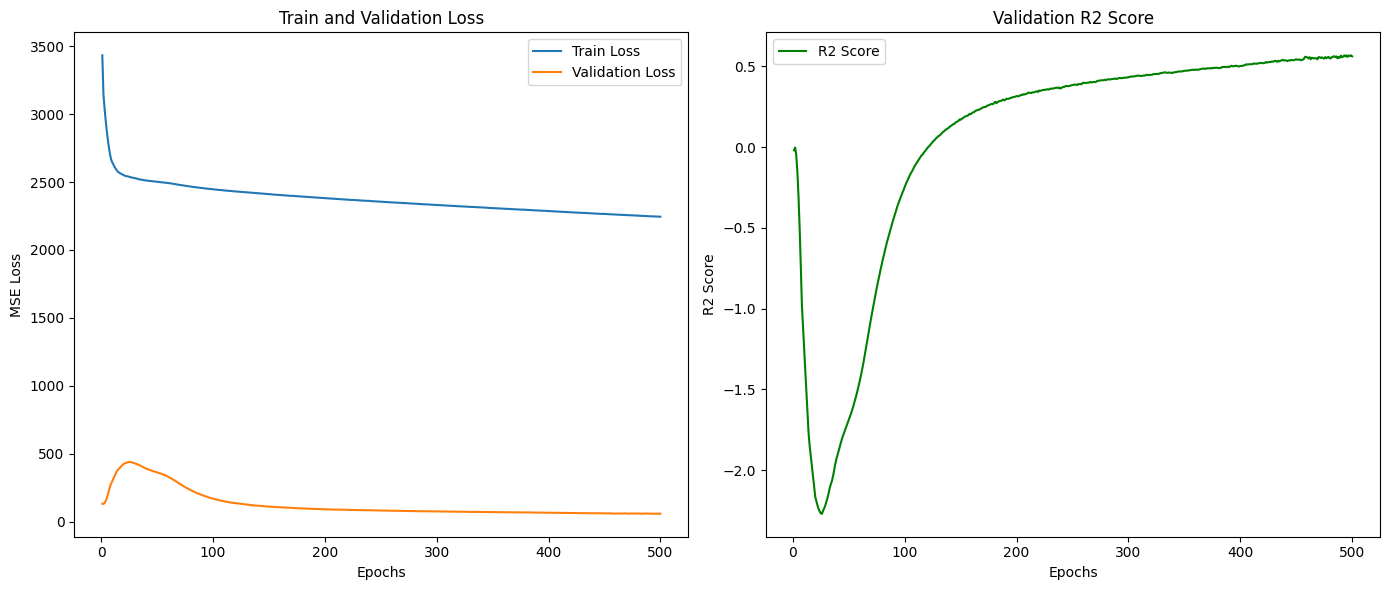

In [145]:
predictor.plot_metrics()

## Inference

In [146]:
test_dataset = FineDustDataset(x_path=test_x, y_path=test_y, sequence_length=168)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [147]:
test_loss, test_r2 = predictor.test(test_loader)

Best model loaded for testing.


Testing: 100%|██████████| 15/15 [00:00<00:00, 82.68it/s]

Test Loss: 394.8267, Test R2 Score: 0.2052


## RESULT
1. 훈련 초반 성능 증가 후 급격한 감소
    - 처음 4-5 에폭 동안 R2 score가 올랐다가, 이후 약 100 에폭 동안 감소한 것으로 보아 모델이 빠르게 overfitting되었을 가능성이 있음.
        - 초기 에폭 동안에는 데이터의 패턴을 학습했으나, 이후 모델이 과도하게 학습하여 트레이닝 데이터에 과적합되기 시작한 것으로 보임
2. 훈련 후반 성능 회복:
    - 훈련 후반부에 약간의 성능 개선이 있었으나, 여전히 훈련 데이터의 R2 score가 0.6에 머문 것은 모델이 충분히 데이터 패턴을 포착하지 못했다는 것을 나타냄.
        - 이는 LSTM 모델이 시간 순서에 따라 데이터를 잘 학습하지 못하거나, 전체적으로 주어진 1년 데이터로는 미세먼지 농도 패턴을 충분히 학습하기 어렵다고 보임
3. 테스트 데이터의 낮은 R2 score:
    - 테스트 R2 score가 0.25로 훈련 데이터보다 매우 낮은데, 이는 모델이 일반화 능력이 부족하다는 것을 의미
        - 모델이 훈련 데이터에 최적화되었으나, 테스트 데이터에 대해 동일한 패턴을 찾지 못하고 성능이 급격히 저하

## Discussion

**계절성과 트렌드 부족**
- 1년치 데이터는 시계열 데이터에서 계절적 패턴을 충분히 학습하기에 부족
- 미세먼지 농도는 계절과 날씨에 따라 크게 변동할 가능성이 있는데, 이러한 장기 패턴을 모델이 충분히 학습할 수 없었다는 문제가 발생한 것으로 보임.</br>

->모델이 특정 계절에 대한 특성을 잘 학습하지 못해 테스트 데이터의 예측 성능이 저하된 것으로 보임.

**데이터 양의 부족**
- 시계열 데이터의 특성상 일정한 시점 간격의 데이터를 장기적으로 학습할 때 더 많은 양의 데이터가 필요
- 1년치 데이터는 LSTM 모델이 학습할 수 있는 충분한 데이터 패턴을 제공하지 못한 것으로 보이며 이로 인해 모델이 제대로 학습되지 못했을 것.